<a href="https://colab.research.google.com/github/connormacs/CNN-PFA/blob/master/PFA_preprocess_PCA_Feb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Preprocess

## import libraries, preprocessing, and set up drive connection

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from sklearn.cluster import KMeans
import tensorflow.keras.backend as K
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans

import random

from scipy.stats import uniform
import pickle
import datetime
import time
import torch
from pathlib import Path
import sys

In [3]:
def timeNow():
    '''
    returns current date as a string
    '''
    now = datetime.datetime.now()
    full = "-" + str(now.month) + "-" + str(now.day) + "-" + str(now.year) + \
           '-' + str(now.hour).zfill(2) + ':' + str(now.minute).zfill(2) + ':' + str(now.second).zfill(2)

    return full

In [4]:
pip install --upgrade tables

Requirement already up-to-date: tables in /usr/local/lib/python3.6/dist-packages (3.6.1)


In [5]:
#Set up directory where data is stored in your google drive

%cd '/content/drive/My Drive/October_PFA'

/content/drive/My Drive/October_PFA


In [6]:
#Import PFA master hdf file preprocessing
import PFA_preprocessing_october2020 as pfa

In [7]:
tf.__version__

'2.4.1'

In [8]:
#To access a gpu (not needed unless for clustering) go to runtime tab, select change runtime type, select GPU then run line to check
tf.config.list_physical_devices('GPU')


[]

## load PFA data

In [9]:
#Dataframe with all features, including domains (under column FIRST_CLAS)
df_test2 = pd.read_hdf('./PFA_Jan_dataframe_2020grid_v2_withError1_df.h5', 'df_features')
df_test2.tail()

,FID,pointid,row,column,NAME,Distance,TrainCode,NullInfo,LocalK-StructuralSetting,LocalK-QuaternaryFaultRecency,LocalK-QuaternaryFaultSlipDilation,LocalK-QuaternaryFaultSlipRate,IntermediateK-QuaternaryFaultTraces,RegionalK-HorizGravityGradient,RegionalK-GeodeticStrainRate,RegionalK-QuaternarySlipRate,RegionalK-FaultRecency,RegionalK-FaultSlipDilationTendency,RegionalK-Earthquakes,HeatSource-T@3km,LocalK-StructuralSetting_Error,LocalK-QuaternaryFaultRecency_Error,LocalK-QuaternaryFaultSlipDilation_Error,LocalK-QuaternaryFaultSlipRate_Error,IntermediateK-QuaternaryFaultTraces_Error,RegionalK-HorizGravityGradient_Error,RegionalK-GeodeticStrainRate_Error,RegionalK-QuaternarySlipRate_Error,RegionalK-FaultRecency_Error,RegionalK-Earthquakes_Error,HeatSource-T@3km_Error,inter_er,lgarece2er,loginverr,qu4sumd_er,reg5moder3,regloc3ber,strset61_n,strset62_n,strset63_n,strset64_n,strset6er_,train_neg,train_p130,train_pos,grav_c,mag_c,hill1km,hill100,hill200,grav2,mag2,dem_1km,Id,id2,hf,hf_se,nv_dem30m,FIRST_CLAS
1727995,1727683,999.0,1723.0,0.0,0.0,0.0,0.0,3.79511,-9999.0,-1.0,2.11394,1.11547,0.397940,0,-9999.0,117.438003,-9999.0,0.0,-9999.0,0.19125,-9999.0,-9999.0,-9999.0,0.0,-9999.0,0.0,nullValue,0.788923,3.31377,17.615601,0.577983,-9999.0,0.403113,0.537311,0.453099,2.43299,2.58782,0.0,0.0,0.0,0.0,0.0,12,12,12,0.190986,4,180,180,183,0.004456,0.000005,1706,0,0,91.726402,22.451099,1703,0
1727996,1727944,999.0,1724.0,0.0,0.0,0.0,0.0,3.79511,-9999.0,-1.0,2.11394,1.11287,0.176091,0,-9999.0,117.438003,-9999.0,0.0,-9999.0,0.19125,-9999.0,-9999.0,-9999.0,0.0,-9999.0,0.0,nullValue,0.788923,3.31951,17.615601,0.577983,-9999.0,0.403113,0.536572,0.468096,2.44081,2.59517,0.0,0.0,0.0,0.0,0.0,12,12,12,0.203718,4,180,180,185,0.004581,0.000005,1706,0,0,91.769501,22.432301,1705,0
1727997,1727945,999.0,1725.0,0.0,0.0,0.0,0.0,3.94809,-9999.0,-1.0,2.11394,1.11287,0.176091,0,-9999.0,117.438003,-9999.0,0.0,-9999.0,0.19125,-9999.0,-9999.0,-9999.0,0.0,-9999.0,0.0,nullValue,0.788923,3.32313,17.615601,0.600598,-9999.0,0.403113,0.535831,0.468096,2.44572,2.59980,0.0,0.0,0.0,0.0,0.0,12,12,12,0.190986,4,180,180,181,0.004699,0.000005,1706,0,0,91.813103,22.413500,1703,0
1727998,1727946,999.0,1726.0,0.0,0.0,0.0,0.0,4.05051,-9999.0,-1.0,2.11394,1.11287,0.176091,0,-9999.0,117.438003,-9999.0,0.0,-9999.0,0.19125,-9999.0,-9999.0,-9999.0,0.0,-9999.0,0.0,nullValue,0.788923,3.32551,17.615601,0.615751,-9999.0,0.403113,0.535089,0.468096,2.44896,2.60284,0.0,0.0,0.0,0.0,0.0,12,12,12,0.165521,4,180,180,180,0.004806,0.000005,1706,0,0,91.857399,22.394600,1702,0
1727999,1727947,999.0,1727.0,0.0,0.0,0.0,0.0,4.05051,-9999.0,-1.0,2.11394,1.11287,0.176091,0,-9999.0,117.438003,-9999.0,0.0,-9999.0,0.19125,-9999.0,-9999.0,-9999.0,0.0,-9999.0,0.0,nullValue,0.788923,3.32511,17.615601,0.615751,-9999.0,0.403113,0.534346,0.468096,2.44842,2.60234,0.0,0.0,0.0,0.0,0.0,12,12,12,0.165521,4,180,180,180,0.004899,0.000005,1707,0,0,91.902298,22.375601,1702,0


In [10]:
#Dataframe with processed features
df_features = pd.read_hdf("./datasets/CMS_PFA_dataframe_2020grid_october2020_df.h5", 'df_features')
#df_features.shape

In [11]:
df_features.tail()

,row,column,id_rc,X_83UTM11,Y_83UTM11,NullInfo,TrainCodeNeg,TrainCodePos,TrainCodePosT130,PosSite130_Id,PosSite130_Distance,PosSite_Id,PosSite_Distance,NegSite_Id,NegSite_Distance,Local_polygon_Id,Local_polygon_overlap_Id,Local-StructuralSetting,Local-QuaternaryFaultRecency,Local-QuaternaryFaultSlipDilation,Local-QuaternaryFaultSlipRate,QuaternaryFaultTraces,HorizGravityGradient,GeodeticStrainRate,QuaternarySlipRate,FaultRecency,FaultSlipDilationTendency,Earthquakes,HeatSource-T@3km,HorizGravityGradient2,HorizMagneticGradient2,GeochemistryTemperature,Heatflow,Tufa_Distance,Travertine_Distance,Silica_Distance,Local-StructuralSetting_Error,Local-QuaternaryFaultRecency_Error,Local-QuaternaryFaultSlipDilation_Error,Local-QuaternaryFaultSlipRate_Error,QuaternaryFaultTraces_Error,HorizGravityGradient_Error,GeodeticStrainRate_Error,QuaternarySlipRate_Error,FaultRecency_Error,FaultSlipDilationTendency_Error,Earthquakes_Error,HeatSource-T@3km_Error,HorizGravityGradient2_Confidence,HorizMagneticGradient2_Confidence,GeochemistryTemperature_Error,Heatflow_Error,Hillshade-100m,DEM-30m,Fairway
1727995,999.0,1723.0,R1000C1724,717077.690182,4.508464e+06,nullValue,12,12,12,16,31591.761299,66,26933.779554,62,64536.261409,0,0,0.0,0.0,0.0,0.0,0,3.79511,-9999.0,-1.0,2.11394,1.11547,0.397940,117.438003,0.004456,0.000005,-9999.0,91.726402,47889.019228,30812.339223,29085.319642,0.0,0.0,0.0,0.0,-9999.0,0.577983,0.537311,0.788923,0.403113,0.0,0.453099,17.615601,0.190986,4,0.0,22.451099,180,1703,-9999.0
1727996,999.0,1724.0,R1000C1725,717327.690182,4.508464e+06,nullValue,12,12,12,16,31791.388144,66,26702.817185,62,64548.055535,0,0,0.0,0.0,0.0,0.0,0,3.79511,-9999.0,-1.0,2.11394,1.11287,0.176091,117.438003,0.004581,0.000005,-9999.0,91.769501,48034.190284,30842.251632,29325.831825,0.0,0.0,0.0,0.0,-9999.0,0.577983,0.536572,0.788923,0.403113,0.0,0.468096,17.615601,0.203718,4,0.0,22.432301,180,1705,-9999.0
1727997,999.0,1725.0,R1000C1726,717577.690182,4.508464e+06,nullValue,12,12,12,16,31991.722966,66,26472.200705,62,64560.815593,0,0,0.0,0.0,0.0,0.0,0,3.94809,-9999.0,-1.0,2.11394,1.11287,0.176091,117.438003,0.004699,0.000005,-9999.0,91.813103,48180.221147,30874.159470,29566.501413,0.0,0.0,0.0,0.0,-9999.0,0.600598,0.535831,0.788923,0.403113,0.0,0.468096,17.615601,0.190986,4,0.0,22.413500,180,1703,-9999.0
1727998,999.0,1726.0,R1000C1727,717827.690182,4.508464e+06,nullValue,12,12,12,16,32192.752546,66,26241.939234,62,64574.541011,0,0,0.0,0.0,0.0,0.0,0,4.05051,-9999.0,-1.0,2.11394,1.11287,0.176091,117.438003,0.004806,0.000005,-9999.0,91.857399,48327.104024,30908.056560,29807.324594,0.0,0.0,0.0,0.0,-9999.0,0.615751,0.535089,0.788923,0.403113,0.0,0.468096,17.615601,0.165521,4,0.0,22.394600,180,1702,-9999.0
1727999,999.0,1727.0,R1000C1728,718077.690182,4.508464e+06,nullValue,12,12,12,16,32394.463951,66,26012.042198,62,64589.231173,0,0,0.0,0.0,0.0,0.0,0,4.05051,-9999.0,-1.0,2.11394,1.11287,0.176091,117.438003,0.004899,0.000005,-9999.0,91.902298,48474.831170,30943.936362,30048.297673,0.0,0.0,0.0,0.0,-9999.0,0.615751,0.534346,0.788923,0.403113,0.0,0.468096,17.615601,0.165521,4,0.0,22.375601,180,1702,-9999.0


In [12]:
df_SSlookup = pd.read_hdf('PFA_structuralSettingsLookup_october2020_df.h5', 'df_SSLookup')
#df_SSlookup.shape

In [13]:
df_SSlookup.head()

,Local_polygon_Id,Local_polygon_overlap_Id,Label,Label2,Label3
0,1,1,AZ,NaN,NaN
1,2,2,FT,NaN,NaN
2,3,3,SO,NaN,NaN
3,4,4,SO,NaN,NaN
4,7,7,SO,NaN,NaN


In [14]:
#df_features.columns

(1728000,)


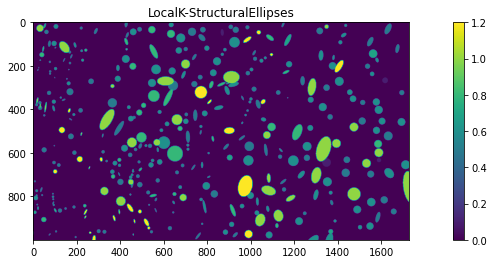

In [15]:
SD = df_features['Local-StructuralSetting'].to_numpy().astype(float)
print(SD.shape)
plt.rc('figure', figsize=(16,4))
SD =np.reshape(SD,(1000,1728))

#invert so it is oriented correctly
SD = np.flipud(SD)
#SD =np.reshape(SD,(1263,1344))
plt.imshow(SD)
plt.title('LocalK-StructuralEllipses')
plt.colorbar()

## preprocess data

In [16]:
extraFeatures = [ \
                 'HorizMagneticGradient2',
                 #'GeochemistryTemperature',
                 'Heatflow',
                 #'Tufa_Distance',
                 #'Travertine_Distance',
                 #'Silica_Distance',
                 #'Hillshade-100m',
                 'DEM-30m'
                ]
# seems adding 'GeochemistryTemperature' really separates (+) and (-)

# extraFeatures = ['HorizMagneticGradient2','DEM-30m']

# extraFeatures = None

Call pfa.preprocess. Coded N for numerical, C for categorical.

N is 0-1.2 scoring for 'Local-StructuralSetting', and C is 19 different structures 1hot encoded (~7 major and 12 hybrid).

The data is reduced (z-score) and scaled (standard). 

Distance from faults = distance_edt, also have option to change to gaussian filter 'gaussianFilter'

In [17]:
dfC, dfInfoC, nullIndexesC, scalerC = pfa.preprocess_features_LocalCategorical(df_features.copy(), df_SSlookup, 
                                                                               resetLocal=None, 
#                                                                                resetLocal='zeros', 
#                                                                                resetLocal='random', 
                                                                               transformFaultTraces='gaussianFilter',
                                                                               extraFeatures=extraFeatures,
                                                                               prescaleFeatures=True)

dfN, dfInfoN, nullIndexesN, scalerN = pfa.preprocess_features_LocalNumerical(df_features.copy(), 
#                                                                               resetLocal=None, 
#                                                                              resetLocal='zeros', 
                                                                             resetLocal='random',
                                                                             transformFaultTraces='gaussianFilter',
                                                                             extraFeatures=extraFeatures, 
                                                                             prescaleFeatures=True)


In [18]:
#Make sure to update data so that Q fault traces = density or distance and that fault recency is inverted (younger = higher values)

dfN = dfN.rename({'QuaternaryFaultTraces':'QuaternaryFaultDensity'},axis=1)
dfC = dfC.rename({'QuaternaryFaultTraces':'QuaternaryFaultDensity'},axis=1)
dfN['FaultRecency'] = dfN['FaultRecency']*-1

In [19]:
dfN['FaultRecency'].head(5)

0   -0.664854
1   -0.664854
2   -0.664854
3   -0.664854
4   -0.640521
Name: FaultRecency, dtype: float64

In [20]:
dfN.columns

Index(['Local-StructuralSetting', 'Local-QuaternaryFaultRecency',
       'Local-QuaternaryFaultSlipDilation', 'Local-QuaternaryFaultSlipRate',
       'QuaternaryFaultDensity', 'HorizGravityGradient2', 'GeodeticStrainRate',
       'QuaternarySlipRate', 'FaultRecency', 'FaultSlipDilationTendency',
       'Earthquakes', 'HeatSource-T@3km', 'HorizMagneticGradient2', 'Heatflow',
       'DEM-30m'],
      dtype='object')

In [21]:
dfC.columns

Index(['Local-StructuralSetting_0', 'Local-StructuralSetting_1',
       'Local-StructuralSetting_2', 'Local-StructuralSetting_3',
       'Local-StructuralSetting_4', 'Local-StructuralSetting_5',
       'Local-StructuralSetting_6', 'Local-StructuralSetting_7',
       'Local-StructuralSetting_8', 'Local-StructuralSetting_9',
       'Local-StructuralSetting_10', 'Local-StructuralSetting_11',
       'Local-StructuralSetting_12', 'Local-StructuralSetting_13',
       'Local-StructuralSetting_14', 'Local-StructuralSetting_15',
       'Local-StructuralSetting_16', 'Local-StructuralSetting_17',
       'Local-StructuralSetting_18', 'Local-QuaternaryFaultRecency',
       'Local-QuaternaryFaultSlipDilation', 'Local-QuaternaryFaultSlipRate',
       'QuaternaryFaultDensity', 'HorizGravityGradient2', 'GeodeticStrainRate',
       'QuaternarySlipRate', 'FaultRecency', 'FaultSlipDilationTendency',
       'Earthquakes', 'HeatSource-T@3km', 'HorizMagneticGradient2', 'Heatflow',
       'DEM-30m'],
      dt

In [22]:
scalerN

[StandardScaler(copy=True, with_mean=True, with_std=True),
 StandardScaler(copy=True, with_mean=True, with_std=True)]

In [23]:
scalerN[1].mean_

array([0.08993668, 0.10431371, 0.03599953, 0.10994937])

In [24]:
dfInfoN.head()

,row,column,id_rc,X_83UTM11,Y_83UTM11,NullInfo,TrainCodeNeg,TrainCodePos,TrainCodePosT130,PosSite130_Id,PosSite130_Distance,PosSite_Id,PosSite_Distance,NegSite_Id,NegSite_Distance,Local_polygon_Id,Local_polygon_overlap_Id
0,0.0,0.0,R1C1,286327.690182,4.258714e+06,notNull,12,12,12,6,20004.876786,6,20004.876786,22,6010.217640,0,0
1,0.0,1.0,R1C2,286577.690182,4.258714e+06,notNull,12,12,12,6,20035.091113,6,20035.091113,22,5880.862672,0,0
2,0.0,2.0,R1C3,286827.690182,4.258714e+06,notNull,12,12,12,6,20068.374538,6,20068.374538,22,5759.459649,0,0
3,0.0,3.0,R1C4,287077.690182,4.258714e+06,notNull,12,12,12,6,20182.038477,6,20182.038477,22,6640.260403,0,0
4,0.0,4.0,R1C5,287327.690182,4.258714e+06,notNull,12,12,12,6,20202.709169,6,20202.709169,22,6494.604523,0,0


## select benchmark sites based on trainCode distance

Select trainCode=1: for 83+ and 62- or trainCode=2: 415+ and 310-


In [25]:
X, y, XyInfo = pfa.makeBenchmarks(dfN, dfInfoN, nullIndexesN, 
                                          trainCode=1, randomize=True, balance=False)

Number of (+):  83   ; Number of (-):  62


In [26]:
# X, y, XyInfo = pfa.makeBenchmarks(dfC, dfInfoC, nullIndexesC, 
#                                   trainCode=1, randomize=True, balance=True)

In [27]:
print( X.shape, y.shape)

(145, 15) (145,)


In [28]:
X.head()

,Local-StructuralSetting,Local-QuaternaryFaultRecency,Local-QuaternaryFaultSlipDilation,Local-QuaternaryFaultSlipRate,QuaternaryFaultDensity,HorizGravityGradient2,GeodeticStrainRate,QuaternarySlipRate,FaultRecency,FaultSlipDilationTendency,Earthquakes,HeatSource-T@3km,HorizMagneticGradient2,Heatflow,DEM-30m
749308,0.287140,0.048634,0.923436,0.688477,-0.996217,0.345583,-0.455208,-1.238783,-0.898591,-0.398652,0.209097,-1.366554,-0.940228,-0.091243,0.231634
341769,0.700191,0.473252,0.646971,0.609370,1.224991,-0.914771,-0.601991,-0.402264,-0.367175,-0.754162,0.444985,0.475869,-1.043273,-1.643686,-0.260997
238563,0.529945,0.186136,0.693375,0.110554,0.608711,-0.560495,1.401143,0.161974,-0.941493,-0.455555,0.648704,-0.292864,-0.095253,-0.003407,-0.583399
726186,0.617266,0.827152,0.255780,0.277290,2.564689,2.425583,1.632089,0.760124,1.297311,0.772849,1.306076,-0.218511,0.842463,0.969911,-0.910960
739825,0.200346,0.585953,0.615916,0.121688,-1.160743,-0.721419,0.965045,-1.466583,1.695831,-0.780192,-0.243843,0.743377,-0.466218,0.748863,-1.571240


In [29]:
XyInfo['T37'] = np.where( ( (XyInfo['TrainCodePosT130']==12) & (XyInfo['TrainCodePos']==1) ), 1, 12) # | ( (df['gender'] == 'female') & (df['pet1'].isin(['cat','dog'] ) ) ), 5, 0)

XyInfo.head()

,row,column,id_rc,X_83UTM11,Y_83UTM11,NullInfo,TrainCodeNeg,TrainCodePos,TrainCodePosT130,PosSite130_Id,PosSite130_Distance,PosSite_Id,PosSite_Distance,NegSite_Id,NegSite_Distance,Local_polygon_Id,Local_polygon_overlap_Id,T37
749308,433.0,1084.0,R434C1085,557327.690182,4.366964e+06,notNull,1,12,12,13,86009.660311,43,48687.202129,50,12738.072238,0,0,12
341769,197.0,1353.0,R198C1354,624577.690182,4.307964e+06,notNull,1,12,12,13,3566.241993,13,3566.241993,13,7243.374119,0,0,12
238563,138.0,99.0,R139C100,311077.690182,4.293214e+06,notNull,12,1,12,10,1415.177337,10,1415.177337,56,74926.051732,188,0,1
726186,420.0,426.0,R421C427,392827.690182,4.363714e+06,notNull,12,1,12,12,13633.379318,12,13633.379318,5,107588.561636,97,0,1
739825,428.0,241.0,R429C242,346577.690182,4.365714e+06,notNull,1,12,12,14,45037.788125,15,32939.123840,10,8923.233371,0,0,12


In [30]:
#Create Dataframe with all training site info
X.reset_index(drop=True, inplace=True)
XyInfo.reset_index(drop=True, inplace=True)

Tsite= pd.concat([X,XyInfo],axis=1).reset_index(drop=True)
Tsite


,Local-StructuralSetting,Local-QuaternaryFaultRecency,Local-QuaternaryFaultSlipDilation,Local-QuaternaryFaultSlipRate,QuaternaryFaultDensity,HorizGravityGradient2,GeodeticStrainRate,QuaternarySlipRate,FaultRecency,FaultSlipDilationTendency,Earthquakes,HeatSource-T@3km,HorizMagneticGradient2,Heatflow,DEM-30m,row,column,id_rc,X_83UTM11,Y_83UTM11,NullInfo,TrainCodeNeg,TrainCodePos,TrainCodePosT130,PosSite130_Id,PosSite130_Distance,PosSite_Id,PosSite_Distance,NegSite_Id,NegSite_Distance,Local_polygon_Id,Local_polygon_overlap_Id,T37
0,0.287140,0.048634,0.923436,0.688477,-0.996217,0.345583,-0.455208,-1.238783,-0.898591,-0.398652,0.209097,-1.366554,-0.940228,-0.091243,0.231634,433.0,1084.0,R434C1085,557327.690182,4.366964e+06,notNull,1,12,12,13,86009.660311,43,48687.202129,50,12738.072238,0,0,12
1,0.700191,0.473252,0.646971,0.609370,1.224991,-0.914771,-0.601991,-0.402264,-0.367175,-0.754162,0.444985,0.475869,-1.043273,-1.643686,-0.260997,197.0,1353.0,R198C1354,624577.690182,4.307964e+06,notNull,1,12,12,13,3566.241993,13,3566.241993,13,7243.374119,0,0,12
2,0.529945,0.186136,0.693375,0.110554,0.608711,-0.560495,1.401143,0.161974,-0.941493,-0.455555,0.648704,-0.292864,-0.095253,-0.003407,-0.583399,138.0,99.0,R139C100,311077.690182,4.293214e+06,notNull,12,1,12,10,1415.177337,10,1415.177337,56,74926.051732,188,0,1
3,0.617266,0.827152,0.255780,0.277290,2.564689,2.425583,1.632089,0.760124,1.297311,0.772849,1.306076,-0.218511,0.842463,0.969911,-0.910960,420.0,426.0,R421C427,392827.690182,4.363714e+06,notNull,12,1,12,12,13633.379318,12,13633.379318,5,107588.561636,97,0,1
4,0.200346,0.585953,0.615916,0.121688,-1.160743,-0.721419,0.965045,-1.466583,1.695831,-0.780192,-0.243843,0.743377,-0.466218,0.748863,-1.571240,428.0,241.0,R429C242,346577.690182,4.365714e+06,notNull,1,12,12,14,45037.788125,15,32939.123840,10,8923.233371,0,0,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,0.839593,0.590046,0.002604,0.445770,-0.516469,3.457460,0.935494,1.944393,0.280747,-0.038748,-0.370134,-0.518965,0.224189,0.287695,-0.549869,532.0,620.0,R533C621,441327.690182,4.391714e+06,notNull,12,1,1,14,41035.057670,27,28985.500481,2,656.737455,129,0,12
141,0.377390,0.526370,0.234146,0.384717,-1.098575,0.294789,-1.074323,-0.258186,-0.037488,-0.050272,-0.643047,1.106248,-0.497131,-0.427854,0.345120,489.0,1498.0,R490C1499,660827.690182,4.380964e+06,notNull,1,12,12,14,126008.675557,26,16702.450168,11,16469.104561,0,0,12
142,0.137945,0.037361,0.348831,0.253417,-0.427361,-1.029075,0.360825,-0.230908,-0.104844,0.692117,0.165248,0.123594,-0.713527,0.642035,0.590146,494.0,887.0,R495C888,508077.690182,4.382214e+06,notNull,12,1,1,14,100809.471288,26,11239.173235,11,17746.761241,231,0,12
143,0.757848,0.235493,0.980734,0.575886,-1.030896,-0.674991,-2.041120,0.626952,-0.350784,1.000273,-1.074379,1.780288,-0.682613,-0.289358,-0.348690,852.0,1295.0,R853C1296,610077.690182,4.471714e+06,notNull,1,12,12,14,26076.299495,14,26076.299495,20,19824.966765,0,0,12


To save df to csv

In [31]:
#Tsite.to_csv(index=False)

#Tsite.to_csv('dfTsite.csv')
#!cp df.csv "/content/drive/My Drive/October_PFA"

## Create a dataframe with all the normalized data


In [32]:
#Create a dataframe with all the normalized data

Info = pd.concat([dfN,dfInfoN],axis=1).reset_index(drop=True)

Info['Local_polygon_Ids'] = df_features['Local_polygon_Id']

#Add domains
Info['Domain'] = df_test2['FIRST_CLAS']
#Add low pos site column
Info['T37'] = np.where( ( (Info['TrainCodePosT130']==12) & (Info['TrainCodeNeg']==12 ) & (Info['TrainCodePos']==1) ), 1, 12) # | ( (df['gender'] == 'female') & (df['pet1'].isin(['cat','dog'] ) ) ), 5, 0)


In [33]:
print (Info['T37'].unique())

[12  1]


In [34]:
#Check how many domains there are, should be 5 (4 plus study area)
print (Info['Domain'].unique())


[1 3 4 0 2]


(1728000,)


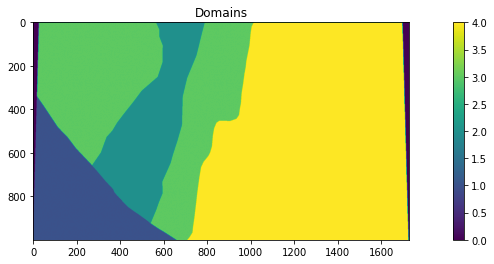

In [35]:
SD = Info['Domain'].to_numpy().astype(float)
print(SD.shape)
plt.rc('figure', figsize=(16,4))
SD =np.reshape(SD,(1000,1728))
#flip it so it is right side up
SD = np.flipud(SD)
#np.fliplr
#SD =np.reshape(SD,(1263,1344))
plt.imshow(SD)
plt.title('Domains')
plt.colorbar()
# 1 wl, 2 cnsb, 3 wgb, 4 carb

## Explore data at training sites

In [36]:
#Create DF's of select features
Tsite_New = Tsite[[	'QuaternaryFaultDensity',	'HorizGravityGradient2',	'GeodeticStrainRate',	'QuaternarySlipRate',	'FaultRecency',	'FaultSlipDilationTendency', 'Earthquakes',	'DEM-30m','Heatflow',	'HorizMagneticGradient2']] #'Local-StructuralSetting',	'Local-QuaternaryFaultRecency',	'Local-QuaternaryFaultSlipDilation',	'Local-QuaternaryFaultSlipRate',

In [37]:
Tsite_New.columns

Index(['QuaternaryFaultDensity', 'HorizGravityGradient2', 'GeodeticStrainRate',
       'QuaternarySlipRate', 'FaultRecency', 'FaultSlipDilationTendency',
       'Earthquakes', 'DEM-30m', 'Heatflow', 'HorizMagneticGradient2'],
      dtype='object')

In [38]:
Tsite_Pos = Tsite[Tsite['TrainCodePos']!=12]
Tsite_Neg = Tsite[Tsite['TrainCodePos']==12]
Tsite_PosLOW = Tsite_Pos[Tsite_Pos['TrainCodePosT130']==12] #lower  pos
Tsite_PosBM = Tsite_Pos[Tsite_Pos['TrainCodePosT130']!=12] #Benchmark  pos

Tsite_Neg_New=Tsite_Neg[['QuaternaryFaultDensity',	'HorizGravityGradient2',	'GeodeticStrainRate',	'QuaternarySlipRate',	'FaultRecency',	'FaultSlipDilationTendency', 'Earthquakes',	'Heatflow',	'HorizMagneticGradient2','DEM-30m']]
Tsite_Pos_New=Tsite_Pos[[	'QuaternaryFaultDensity',	'HorizGravityGradient2',	'GeodeticStrainRate',	'QuaternarySlipRate',	'FaultRecency','FaultSlipDilationTendency', 'Earthquakes',	'Heatflow',	'HorizMagneticGradient2','DEM-30m']]
Tsite_PosLOW_New=Tsite_PosLOW[['QuaternaryFaultDensity',	'HorizGravityGradient2',	'GeodeticStrainRate',	'QuaternarySlipRate',	'FaultRecency',	'FaultSlipDilationTendency', 'Earthquakes',	'Heatflow',	'HorizMagneticGradient2','DEM-30m']]
Tsite_PosBM_New=Tsite_PosBM[['QuaternaryFaultDensity',	'HorizGravityGradient2',	'GeodeticStrainRate',	'QuaternarySlipRate',	'FaultRecency',	'FaultSlipDilationTendency', 'Earthquakes',	'Heatflow',	'HorizMagneticGradient2','DEM-30m']]

Tsite_Pos_New.shape

(83, 10)

## Explore data at structures

In [39]:
df_Struct = Info.copy().loc[Info['Local_polygon_Id'] != 0] #this data frame is only for cells within structures
#Convert structures to point data by taking mean values, crude
df_mean_struct = df_Struct.groupby('Local_polygon_Id').mean()

#Reindex structures, there may be 384 total, but they are grouped so that there are actuall 365 and 19 hybrid 
df_mean_struct.index = range(len(df_mean_struct))
Struc_New = df_mean_struct[['QuaternaryFaultDensity', 'HorizGravityGradient2', 'GeodeticStrainRate','QuaternarySlipRate', 'FaultRecency', 'FaultSlipDilationTendency','Earthquakes', 'Heatflow', 'HorizMagneticGradient2','DEM-30m']]

#Make a label dataframe of which structures host Known Geothermal Systems to append after groupby transformation
yStruct = (df_Struct.groupby(['Local_polygon_Id'])['TrainCodePos'].min())
yStruct.index = range(len(yStruct))
yStruct = pd.DataFrame(yStruct) #.replace({4:12,9:12,10:12,6:12,8:12,7:12}, inplace=True)
yStruct['TrainCodePos'].replace({4:12,9:12,10:12,6:12,8:12,7:12}, inplace=True)

print (yStruct['TrainCodePos'].unique())


[12  1]


In [40]:
yStruct['TrainCodePos'].replace({4:12,9:12,10:12,6:12,8:12,7:12}, inplace=True)

print (yStruct['TrainCodePos'].unique())


[12  1]


In [41]:
Struc_New_labeled = pd.concat([Struc_New,yStruct], axis=1).reset_index(drop=True)
Struc_New_labeled


,QuaternaryFaultDensity,HorizGravityGradient2,GeodeticStrainRate,QuaternarySlipRate,FaultRecency,FaultSlipDilationTendency,Earthquakes,Heatflow,HorizMagneticGradient2,DEM-30m,TrainCodePos
0,-0.704000,-0.432776,-1.006689,-0.396136,0.114169,-0.041161,-0.901236,-0.438549,-0.580153,0.665893,12
1,-0.672007,0.637476,-1.004970,0.242611,1.139096,1.065111,-1.319376,-0.302742,-0.744275,0.356982,12
2,0.262029,-0.122853,-0.391055,0.244396,0.174963,-0.090532,-1.621019,-0.558510,0.078239,0.407686,12
3,0.690652,-0.293934,-0.896395,0.335105,-0.072288,-0.008059,-2.085632,-0.450408,0.189505,0.491438,12
4,-0.061251,0.588092,-1.135228,2.018087,1.612969,0.450483,0.664133,-1.599729,-0.991125,0.336307,12
...,...,...,...,...,...,...,...,...,...,...,...
360,1.579766,0.715068,-0.538849,-0.759298,-0.665293,-0.596084,-0.321885,-0.687452,-0.601185,0.936105,12
361,-0.578005,0.014247,-0.246328,-0.415788,-0.262435,-0.130414,-0.916798,-1.150228,-0.852408,1.018112,12
362,-1.439074,-0.193307,-0.039269,-0.548321,-0.945661,-0.448291,0.671421,-1.784494,-0.448559,-0.965291,12
363,-0.246068,0.050348,-0.352414,-1.546413,-0.543090,0.366914,0.405928,-0.881272,-0.111477,0.273821,1


## Explore data at domains

In [42]:
Carb = Info[Info['Domain'] == 4]
WL = Info[Info['Domain'] == 1]
CNSB =  Info[Info['Domain'] == 2]
WGB =  Info[Info['Domain'] == 3]

FRWY = Info[[	'QuaternaryFaultDensity',	'HorizGravityGradient2',	'GeodeticStrainRate',	'QuaternarySlipRate',	'FaultRecency',	'FaultSlipDilationTendency', 'Earthquakes',	'DEM-30m','Heatflow',	'HorizMagneticGradient2']] #'Local-StructuralSetting',	'Local-QuaternaryFaultRecency',	'Local-QuaternaryFaultSlipDilation',	'Local-QuaternaryFaultSlipRate',

CarbAq = Carb[[	'QuaternaryFaultDensity',	'HorizGravityGradient2',	'GeodeticStrainRate',	'QuaternarySlipRate',	'FaultRecency',	'FaultSlipDilationTendency', 'Earthquakes',	'DEM-30m','Heatflow',	'HorizMagneticGradient2']] #'Local-StructuralSetting',	'Local-QuaternaryFaultRecency',	'Local-QuaternaryFaultSlipDilation',	'Local-QuaternaryFaultSlipRate',
WalkLne = WL[[	'QuaternaryFaultDensity',	'HorizGravityGradient2',	'GeodeticStrainRate',	'QuaternarySlipRate',	'FaultRecency',	'FaultSlipDilationTendency', 'Earthquakes',	'DEM-30m','Heatflow',	'HorizMagneticGradient2']] #'Local-StructuralSetting',	'Local-QuaternaryFaultRecency',	'Local-QuaternaryFaultSlipDilation',	'Local-QuaternaryFaultSlipRate',
CentNevSeisB = CNSB[[	'QuaternaryFaultDensity',	'HorizGravityGradient2',	'GeodeticStrainRate',	'QuaternarySlipRate',	'FaultRecency',	'FaultSlipDilationTendency', 'Earthquakes',	'DEM-30m','Heatflow',	'HorizMagneticGradient2']] #'Local-StructuralSetting',	'Local-QuaternaryFaultRecency',	'Local-QuaternaryFaultSlipDilation',	'Local-QuaternaryFaultSlipRate',
westGB = WGB[[	'QuaternaryFaultDensity',	'HorizGravityGradient2',	'GeodeticStrainRate',	'QuaternarySlipRate',	'FaultRecency',	'FaultSlipDilationTendency', 'Earthquakes',	'DEM-30m','Heatflow',	'HorizMagneticGradient2']] #'Local-StructuralSetting',	'Local-QuaternaryFaultRecency',	'Local-QuaternaryFaultSlipDilation',	'Local-QuaternaryFaultSlipRate',

#PCA Analysis

## Tsite PCA and biplots

https://ostwalprasad.github.io/machine-learning/PCA-using-python.html

https://towardsdatascience.com/principal-components-analysis-plot-for-python-311013a33cd9

<function matplotlib.pyplot.tight_layout>

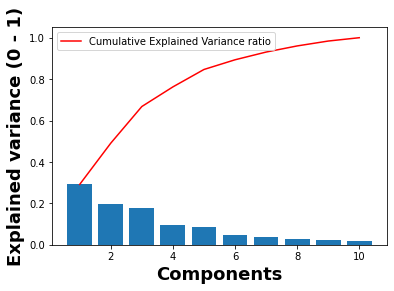

In [43]:
from sklearn.decomposition import PCA
pcamodel = PCA(n_components=10)
pca = pcamodel.fit_transform (Tsite_New)

score = pca[:,0:2]
score[:,0].shape

xs = score[:,0]
ys = score[:,1]

pca.shape
plt.figure(figsize=(6,4))
#plt.figsize=(20.7,6.27)
plt.bar(range(1,len(pcamodel.explained_variance_ratio_ )+1),pcamodel.explained_variance_ratio_) #width=0.5
plt.ylabel('Explained variance (0 - 1)',fontsize = 18,fontweight='bold')
plt.xlabel('Components',fontsize = 18,fontweight='bold')# fontsize=18,fontweight='bold'
#plt.title(r"Training Sites: Explained Variance" + "\n" + "for Each Principal Component ",fontsize=28,fontweight='bold')


#plt.title('NMF distribution at Structures\n2D NMF/Kmeans clusters - ' + ' Numerical Features',fontsize=14,fontweight='bold');

plt.plot(range(1,len(pcamodel.explained_variance_ratio_ )+1),
         np.cumsum(pcamodel.explained_variance_ratio_),
         c='red',
         label="Cumulative Explained Variance ratio")
plt.legend(loc='upper left',fontsize = 10)
plt.tight_layout
#plt.plot(range(1,11),pcamodel.explained_variance_ratio_)

In [44]:
pcamodel.explained_variance_ratio_

#Truncate PCA's if first 3 or 4 account for most of the variance
var_ratio1 = float(str(round(pcamodel.explained_variance_ratio_[0]*100, 2)))
var_ratio2 = float(str(round(pcamodel.explained_variance_ratio_[1]*100, 2)))
var_ratio3 = float(str(round(pcamodel.explained_variance_ratio_[2]*100, 2)))
var_ratio4 = float(str(round(pcamodel.explained_variance_ratio_[3]*100, 2)))

var_ratio1+var_ratio2+var_ratio3

66.78

<function matplotlib.pyplot.tight_layout>

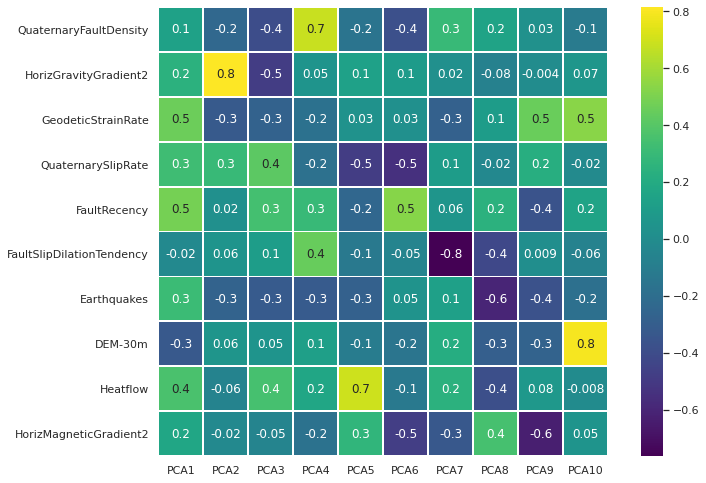

In [45]:
import seaborn as sns
#we can see influence on each of the components by features.
#fig= plt.figure(figsize=(18,13.5))
pcamodel.components_t= pcamodel.components_.transpose()

#ax.xaxis.set_tick_params(labelsize=20)

#im = ax.imshow(W.transpose(), cmap = 'viridis') # cmap='YlGnBu'

sns.set(rc={'figure.figsize':(11.7,8.27),"font.size":20,"axes.labelsize":20},style="white")
ax = sns.heatmap(pcamodel.components_t,  cmap = 'viridis',
                  linewidths=.95,
                 xticklabels=([ "PCA"+str(Tsite_New) for Tsite_New  in range(1,pcamodel.n_components_+1)]),
                 yticklabels=list(Tsite_New.columns), 
                 annot=True, annot_kws={"size": 12}, fmt='.1g',
                 cbar_kws={"orientation": "vertical"})
#xticklabels_kws={"size":15} #np.sort(yticklabels)[::-1]
#ax.set_xlabel("X Label",fontsize=30)
ax.fontweight='bold'
ax.set_aspect("equal")
#ax.set_tick_params(labelsize = 20)
#ax.set_xticklabels(labelsize = 20)
#ax.invert_yaxis()
plt.tight_layout
#plt.savefig('TSitePCA.png')

Text(0.5, 1.0, 'PCA Traincode 1 training sites (145)')

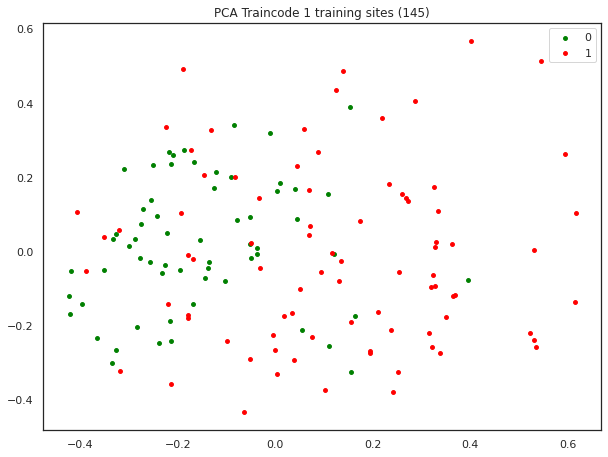

In [46]:
#n = coeff.shape[0]
scalex = 2.5/(xs.max() - xs.min())
scaley = 2.5/(ys.max() - ys.min())
#plt.scatter(xs * scalex,ys * scaley,s=5)


scalex = 1.0/(xs.max() - xs.min())
scaley = 1.0/(ys.max() - ys.min())

#plt.scatter(xs * scalex,ys * scaley,s=5)
fig= plt.figure(figsize=(10,7.5))
plt.scatter(pca[y == 0,0]*scalex,pca[y == 0,1]*scalex, color='green',s=15, label='0')
plt.scatter(pca[y == 1,0]*scaley,pca[y == 1,1]*scaley, color='red',s=15, label='1')
plt.legend(scatterpoints=1)
plt.title('PCA Traincode 1 training sites (145)')


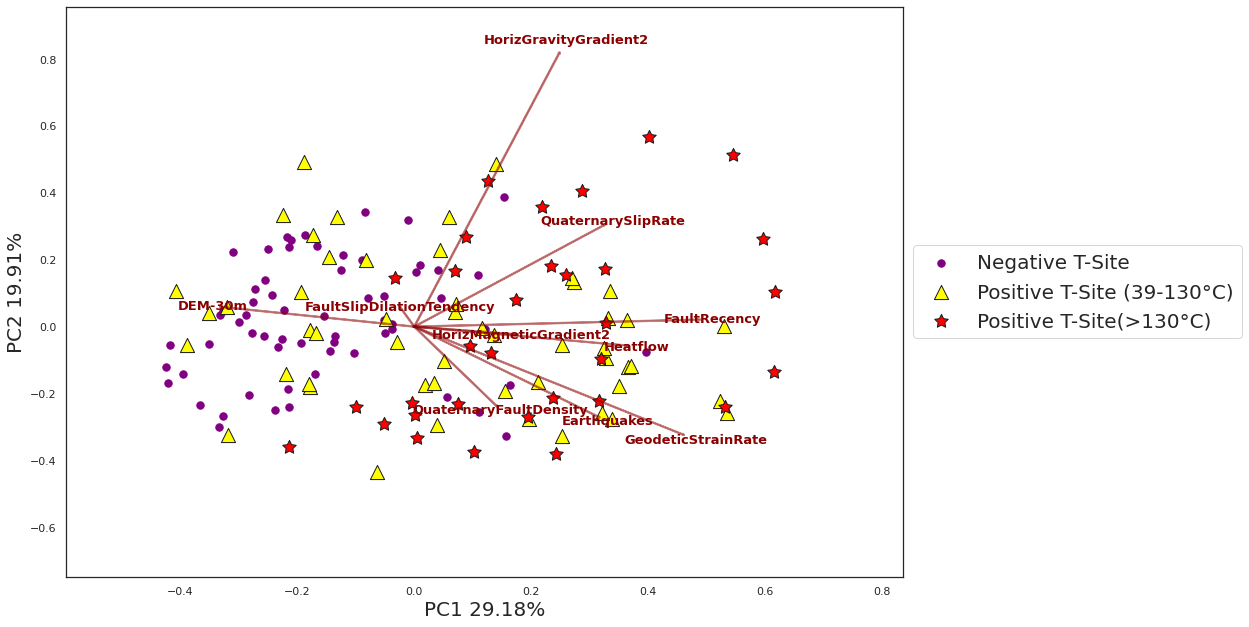

<function matplotlib.pyplot.tight_layout>

In [47]:

from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

score = pca[:,0:2]
score[:,0].shape

#This function plots loading vectors 
def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 2.0/(xs.max() - xs.min())
    scaley = 2.0/(ys.max() - ys.min())
    #plt.scatter(xs * scalex,ys * scaley,s=5)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'darkred',alpha = 0.5, lw = 2 )
        if labels is None:
            plt.text(coeff[i,0]* 1.05, coeff[i,1] * 1.05, "Var"+str(i+1), color = 'k', ha = 'center', va = 'center')
#            plt.text(coeff[i,0]*0.95, coeff[i,1]*0.95, "Var"+str(i+1), color = 'green', ha = 'center', va = 'center')

        else:
            plt.text(coeff[i,0]* 1.05, coeff[i,1] * 1.05, labels[i], color = 'darkred', ha = 'center', va = 'center',fontsize=13, fontweight = 'bold')
       #     plt.text(coeff[i,0], coeff[i,1], labels[i], color = 'g', ha = 'center', va = 'center')
 
    plt.xlabel('PC1 ' + str(var_ratio1) + '%',fontsize=20)
    plt.ylabel('PC2 ' + str(var_ratio2) + '%',fontsize=20)
   # plt.grid()


fig= plt.figure(figsize=(15,10.5)) #,linewidth=10, edgecolor="#04253a")
plt.scatter(pca[y == 0,0]*scalex,pca[y == 0,1]*scalex, color='purple',s=55, label='Negative T-Site')
plt.scatter(pca[Tsite['T37'] == 1,0]*scaley,pca[Tsite['T37'] == 1,1]*scaley, color='yellow',edgecolors='k',s=200,marker='^',label='Positive T-Site (39-130°C)')
plt.scatter(pca[Tsite['TrainCodePosT130'] == 1,0]*scaley,pca[Tsite['TrainCodePosT130'] == 1,1]*scaley, color='red',edgecolors='k',s=200,marker=(5, 1),label='Positive T-Site(>130°C)')


#plt.scatter(z['X_83UTM11'],z['Y_83UTM11'], c = 'red', edgecolors='k', s=165, marker=(5, 1), label = labelS)


myplot(pca[:,0:2],np.transpose(pcamodel.components_[0:2 :]),list(Tsite_New.columns))
scale_factor = 1.55

scale_factor_x = 1.25

xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()

plt.xlim(xmin * scale_factor_x, xmax * scale_factor_x)
plt.ylim(ymin * scale_factor, ymax * scale_factor)


plt.legend(scatterpoints=1,loc='center left',bbox_to_anchor=(1, 0.5),fontsize=20)
#plt.legend(handles=[p1, p2], title='title', bbox_to_anchor=(1.05, 1), loc='upper left', prop=fontP)
#plt.title(r"Training Sites: Non-compositional distance biplots" + "\n" + "of first two principal components.",fontsize=28,fontweight='bold')

plt.show()
plt.tight_layout
#plt.savefig('TSitePCAbiplot.png')


### PCA reconstructions for clustering

In [48]:
Tsite_New['PC1'] = pca[:,0]
Tsite_New['PC2'] = pca[:,1]
Tsite_New['PC3'] = pca[:,2]
Tsite_New['PC4'] = pca[:,3]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

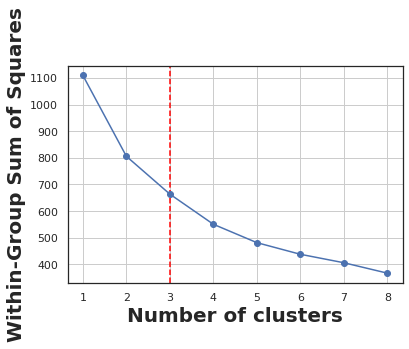

In [49]:
plt.figure(figsize=(6,4))

distortions = []
for i in range(1, 9):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, 
        max_iter=50,
        tol=1e-04, random_state=0
    ) 

    #K-means on the first 4 or so PCs which explain the most variance
    km.fit(Tsite_New[['PC1','PC2','PC3','PC4']])
    distortions.append(km.inertia_)

xposition = [3]
for xc in xposition:
    plt.axvline(x=xc, color='red', linestyle='--')
 
# plot
#plt.plot(figsize =(10,10))
plt.plot(range(1, 9), distortions, marker='o')
plt.xlabel('Number of clusters',fontweight='bold')
plt.ylabel('Within-Group Sum of Squares',fontweight='bold')
#plt.title('Pos sites K vs distortion')

plt.grid()
plt.show()

### PCA Kmeans clustering

In [50]:
TSP_reset = Tsite_New.reset_index( drop=True,inplace = False, col_level=0, col_fill='')
TSP = pd.DataFrame(TSP_reset)
from sklearn.cluster import KMeans
cols = TSP.columns


nCluster = 3

KmeanPP = KMeans(n_clusters=nCluster, init='k-means++',
               verbose=2, algorithm="elkan",
               n_init=10, max_iter=300, tol=0.000001)

KmeanPP.fit(TSP[['PC1','PC2']])

Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 369.2874281181772
start iteration
done sorting
end inner loop
Iteration 1, inertia 287.29111354748915
start iteration
done sorting
end inner loop
Iteration 2, inertia 284.28197307827514
start iteration
done sorting
end inner loop
Iteration 3, inertia 280.9035239265978
start iteration
done sorting
end inner loop
Iteration 4, inertia 279.8654520794021
start iteration
done sorting
end inner loop
Iteration 5, inertia 279.8654520794021
center shift 0.000000e+00 within tolerance 2.461610e-06
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 338.29057378994423
start iteration
done sorting
end inner loop
Iteration 1, inertia 308.47163520878655
start iteration
done sorting
end inner loop
Iteration 2, inertia 288.79727534928304
start iteration
done sorting
end inner loop
Iteration 3, inertia 285.5930921847768
start iteration
done sorting
end inner loop
Iteration 4, iner

KMeans(algorithm='elkan', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=1e-06, verbose=2)

In [51]:
centers = np.copy(KmeanPP.cluster_centers_)
print('centers.ndim: {}'.format(centers.ndim))
print('centers.shape: {}'.format(centers.shape))
print('centers.size: {}'.format(centers.size))
print(centers)

Labels = KmeanPP.labels_

centers.ndim: 2
centers.shape: (3, 2)
centers.size: 6
[[-1.45322164 -0.59709256]
 [ 1.79439867 -0.73233569]
 [-0.08243757  1.72965972]]


In [52]:
df_labels = pd.DataFrame({'KMeansGrp':Labels,
                          'Grp0_CntrX':centers[0,0],
                          'Grp0_CntrY':centers[0,1],
                          'Grp1_CntrX':centers[1,0],
                          'Grp1_CntrY':centers[1,1]})

df_out = pd.concat([TSP, Tsite, df_labels], axis=1, sort=False)

print("Last 5 rows of df_out:", file=sys.stdout, flush=True)
print(df_out.tail(5).to_string(), file=sys.stdout, flush=True)
print('', file=sys.stdout, flush=True)

Last 5 rows of df_out:
     QuaternaryFaultDensity  HorizGravityGradient2  GeodeticStrainRate  QuaternarySlipRate  FaultRecency  FaultSlipDilationTendency  Earthquakes   DEM-30m  Heatflow  HorizMagneticGradient2       PC1       PC2       PC3       PC4  Local-StructuralSetting  Local-QuaternaryFaultRecency  Local-QuaternaryFaultSlipDilation  Local-QuaternaryFaultSlipRate  QuaternaryFaultDensity  HorizGravityGradient2  GeodeticStrainRate  QuaternarySlipRate  FaultRecency  FaultSlipDilationTendency  Earthquakes  HeatSource-T@3km  HorizMagneticGradient2  Heatflow   DEM-30m    row  column      id_rc      X_83UTM11     Y_83UTM11 NullInfo  TrainCodeNeg  TrainCodePos  TrainCodePosT130  PosSite130_Id  PosSite130_Distance  PosSite_Id  PosSite_Distance  NegSite_Id  NegSite_Distance  Local_polygon_Id  Local_polygon_overlap_Id  T37  KMeansGrp  Grp0_CntrX  Grp0_CntrY  Grp1_CntrX  Grp1_CntrY
140               -0.516469               3.457460            0.935494            1.944393      0.280747      

In [53]:
group1 = df_out[(df_out['TrainCodePosT130'] == 1) & (df_out['KMeansGrp'] == 0)] #plot with star
group2 = df_out[(df_out['TrainCodePosT130'] == 12) & (df_out['TrainCodeNeg'] == 12) & (df_out['KMeansGrp'] == 0)] #plot with triangle
group3 = df_out[(df_out['TrainCodeNeg'] == 1) & (df_out['KMeansGrp'] == 0)]


group4 = df_out[(df_out['TrainCodePosT130'] == 1) & (df_out['KMeansGrp'] == 1)] #plot with star
group5 = df_out[(df_out['TrainCodePosT130'] == 12) & (df_out['TrainCodeNeg'] == 12) & (df_out['KMeansGrp'] == 1)]
group6 = df_out[(df_out['TrainCodeNeg'] == 1) & (df_out['KMeansGrp'] == 1)]

group7 = df_out[(df_out['TrainCodePosT130'] == 1) & (df_out['KMeansGrp'] == 2)] #plot with star
group8 = df_out[(df_out['TrainCodePosT130'] == 12) & (df_out['TrainCodeNeg'] == 12) & (df_out['KMeansGrp'] == 2)]
group9 = df_out[(df_out['TrainCodeNeg'] == 1) & (df_out['KMeansGrp'] == 2)]


In [54]:
centers.shape

(3, 2)

In [55]:
label1 = 'Positive T-Site(>130°C) - Cluster 1'
label2 = 'Positive T-Site (39-130°C) - Cluster 1'
label3 = 'Negative T-Site - Cluster 1'


label4 = 'Positive T-Site(>130°C) - Cluster 2'
label5 = 'Positive T-Site (39-130°C) - Cluster 2'
label6 = 'Negative T-Site - Cluster 2'

label7 = 'Positive T-Site (>130°C) - Cluster 3'
label8 = 'Positive T-Site (39-130°C) - Cluster 3'
label9 = 'Negative T-Site - Cluster 3'

The radius of each circle is the distance between the centroid and points in each cluster, either the min, mean, or max dist of the collection of points. Not sure how to make colors match clusters, for now I just do that in photoshop

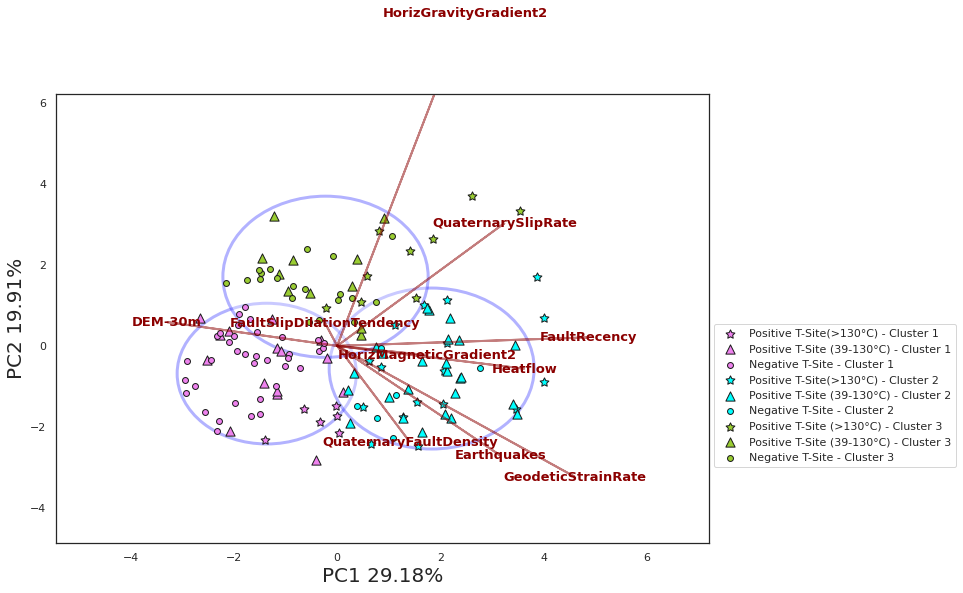

In [57]:
#plot kmeans data
from scipy.spatial.distance import cdist

plt.scatter(group1['PC1'], group1['PC2'], c='violet',edgecolors='k',s=85,marker=(5, 1), label=label1)
plt.scatter(group2['PC1'], group2['PC2'], c='violet',edgecolors='k',s=85, marker='^',label=label2)            
plt.scatter(group3['PC1'], group3['PC2'], c='violet',edgecolors='k',s=35, marker='o',label=label3)
            
plt.scatter(group4['PC1'], group4['PC2'], c='cyan' ,edgecolors='k',s=85, marker=(5, 1), label=label4)   
plt.scatter(group5['PC1'], group5['PC2'], c='cyan',edgecolors='k',s=85, marker='^',label=label5)
plt.scatter(group6['PC1'], group6['PC2'], c='cyan',edgecolors='k',s=35, marker='o',label=label6)            

plt.scatter(group7['PC1'], group7['PC2'], c='yellowgreen',edgecolors='k',s=85, marker=(5, 1),label=label7)
plt.scatter(group8['PC1'], group8['PC2'], c='yellowgreen',edgecolors='k',s=85, marker='^',label=label8)     
plt.scatter(group9['PC1'], group9['PC2'], c='yellowgreen',edgecolors='k',s=35, marker='o',label=label9)

#ADD ELLIPSES
def plot_kmeans(kmeans, X, n_clusters=3, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
    #ax.axis('equal') #equal makes them circles
    #ax.set_ylim(-5000,7000)
    #ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_ 
    radii = [cdist(X[labels == i], [center]).mean()*0.75
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='white',ec ='blue', lw=3, alpha = 0.3, zorder=.1))

#ADD VECTORS
def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    #plt.scatter(xs * scalex,ys * scaley,s=5, color ='white')
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0]*10, coeff[i,1]*10,color = 'darkred',alpha = 0.5, lw = 2 )
        if labels is None:
            plt.text(coeff[i,0]* 1.05, coeff[i,1] * 1.05, "Var"+str(i+1), color = 'k', ha = 'center', va = 'center',)
#            plt.text(coeff[i,0]*0.95, coeff[i,1]*0.95, "Var"+str(i+1), color = 'green', ha = 'center', va = 'center')

        else:
            plt.text(coeff[i,0]* 10.05, coeff[i,1] * 10.05, labels[i], color = 'darkred', ha = 'center', va = 'center',fontsize=13,fontweight='bold')
       #     plt.text(coeff[i,0], coeff[i,1], labels[i], color = 'g', ha = 'center', va = 'center')
 
    plt.xlabel('PC1 ' + str(var_ratio1) + '%',fontsize=20)
    plt.ylabel('PC2 ' + str(var_ratio2) + '%',fontsize=20)


scale_factor = 1.55

scale_factor_x = 1.65

xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()

plt.xlim(xmin * scale_factor_x, xmax * scale_factor_x)
plt.ylim(ymin * scale_factor, ymax * scale_factor)        
kmeans = KMeans(n_clusters=3, random_state=0)

plot_kmeans(kmeans, pca) # hash out to turn off ellipses

myplot(pca[:,0:2],np.transpose(pcamodel.components_[0:2, :]),list(TSP.columns))

#scale_factor = 1.55
plt.legend(loc='best',bbox_to_anchor=(1, 0.5))
#scale_factor_x = 1.25
#plt.grid(True)
#plt.title('KMeans Analysis with\n2D PCA clusters - ' + ' dfN' ' local',fontsize=14);


### Projection into fairway

In [58]:
#Tsite.reset_index(inplace = True) 
group1_info = pd.concat([group1,Tsite], axis=1, sort=False).dropna()
group2_info = pd.concat([group2,Tsite], axis=1, sort=False).dropna()
group3_info = pd.concat([group3,Tsite], axis=1, sort=False).dropna()
group4_info = pd.concat([group4,Tsite],axis=1, sort=False).dropna()
group5_info = pd.concat([group5,Tsite],axis=1, sort=False).dropna()
group6_info = pd.concat([group6,Tsite],axis=1, sort=False).dropna()
group7_info = pd.concat([group7,Tsite],axis=1, sort=False).dropna()
group8_info = pd.concat([group8,Tsite],axis=1, sort=False).dropna()
group9_info = pd.concat([group9,Tsite],axis=1, sort=False).dropna()

(1728000,)


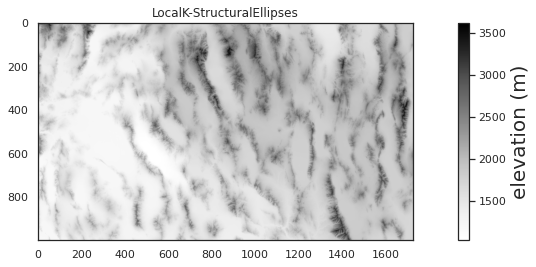

In [59]:
#Set up DEM that isn't normalized (original values) to overlay data on
selected_columns = df_features[['DEM-30m','X_83UTM11','Y_83UTM11']]
df_DEM = selected_columns.copy()
SD = df_DEM['DEM-30m'].to_numpy().astype(float)
print(SD.shape)
plt.rc('figure', figsize=(16,4))
SD =np.reshape(SD,(1000,1728))
#SD =np.reshape(SD,(1263,1344))
plt.imshow(SD,cmap ='Greys')
plt.title('LocalK-StructuralEllipses')

plt.colorbar(label = 'elevation (m)')

<function matplotlib.pyplot.tight_layout>

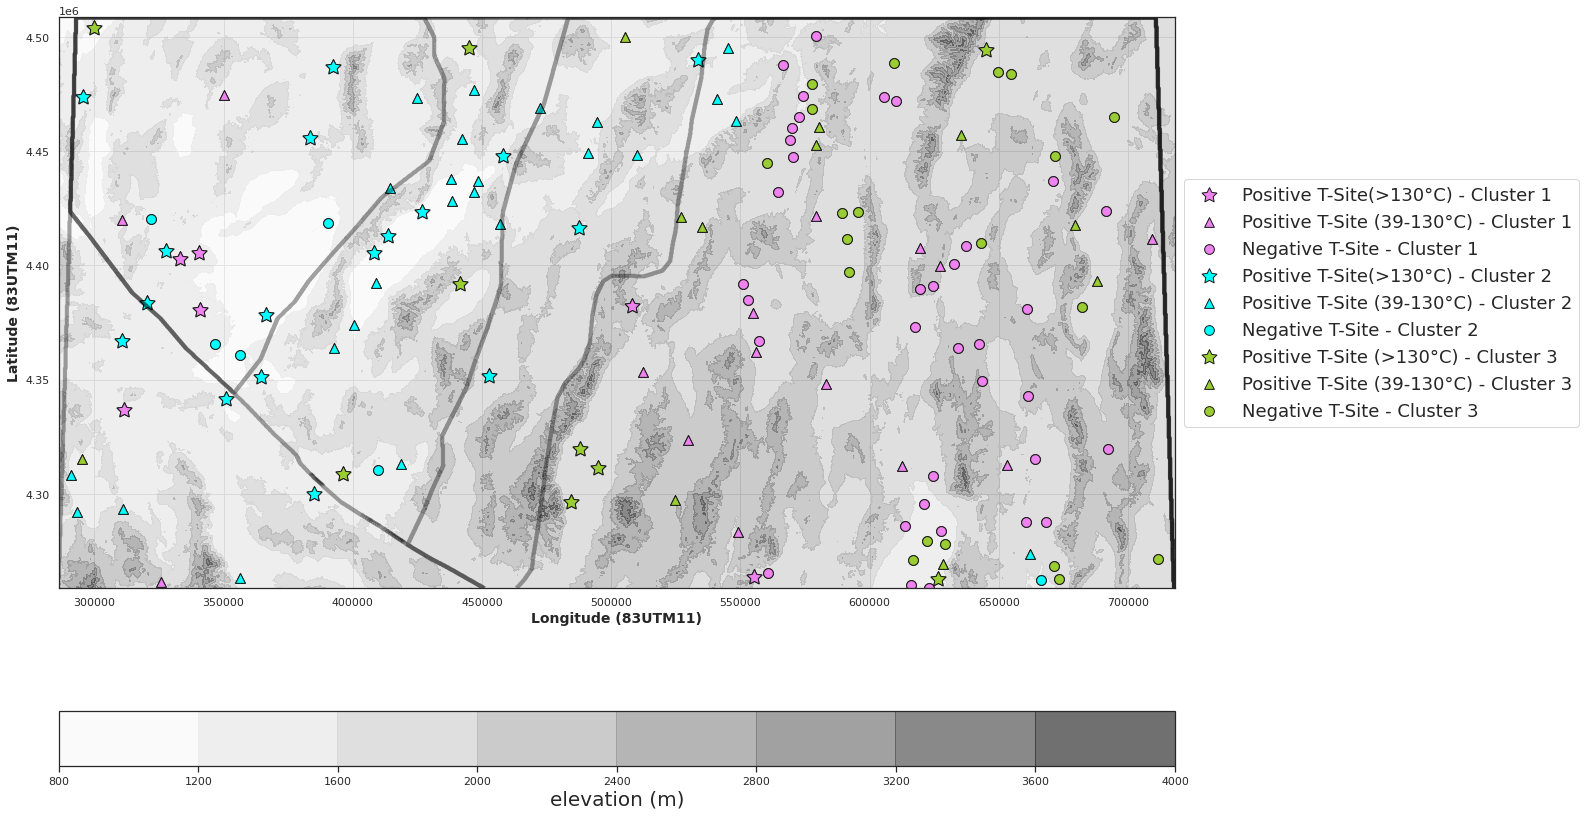

In [60]:
plt.subplots(figsize=(20,15))

a = df_features['X_83UTM11']
b = df_features['Y_83UTM11']
s = df_features['QuaternaryFaultTraces']

Z = Info.pivot_table(index='X_83UTM11', columns='Y_83UTM11', values='Domain').T.values #-9999 in strain messses it up

Za = df_DEM.pivot_table(index='X_83UTM11', columns='Y_83UTM11', values='DEM-30m').T.values #-9999 in strain messses it up

X_unique = np.sort(a.unique())
Y_unique = np.sort(b.unique())
Xa, Ya = np.meshgrid(X_unique, Y_unique)
pd.DataFrame(Z)

#plt.subplot(2,2,1)
plt.rcParams["figure.figsize"] = (20,10)

alpha = 0.7

plt.contour(Xa,Ya,Z,colors='black', linewidths=4, alpha=0.2) #cmap = 'terrain'

plt.contourf(Xa,Ya,Za,cmap = 'Greys', alpha=0.6)
plt.colorbar(label = 'elevation (m)',orientation= 'horizontal')


plt.scatter(group1_info['X_83UTM11'], group1_info['Y_83UTM11'], c='violet',edgecolors='k', marker=(5, 1),s=245, label=label1)
plt.scatter(group2_info['X_83UTM11'], group2_info['Y_83UTM11'],  c='violet', edgecolors='k',marker='^',s=95, label=label2)
plt.scatter(group3_info['X_83UTM11'], group3_info['Y_83UTM11'],  c='violet',edgecolors='k', marker='o',s=95, label=label3)
plt.scatter(group4_info['X_83UTM11'], group4_info['Y_83UTM11'],  c='cyan', edgecolors='k',marker=(5, 1),s=245, label=label4)
plt.scatter(group5_info['X_83UTM11'], group5_info['Y_83UTM11'],  c='cyan',edgecolors='k', marker='^',s=95, label=label5)
plt.scatter(group6_info['X_83UTM11'], group6_info['Y_83UTM11'],  c='cyan',edgecolors='k', marker='o',s=95, label=label6)
plt.scatter(group7_info['X_83UTM11'], group7_info['Y_83UTM11'],  c='yellowgreen', edgecolors='k',marker=(5, 1),s=245,label=label7)
plt.scatter(group8_info['X_83UTM11'], group8_info['Y_83UTM11'],  c='yellowgreen', marker='^',s=95,edgecolors='k', label=label8)
plt.scatter(group9_info['X_83UTM11'], group9_info['Y_83UTM11'],  c='yellowgreen', marker='o',edgecolors='k',s=95,label=label9)

plt.xlabel('Longitude (83UTM11)',fontsize=14,fontweight='bold')
plt.ylabel('Latitude (83UTM11)',fontsize=14,fontweight='bold')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize = 18)
plt.grid(True)
#plt.colorbar(orientation= 'horizontal')

#plt.title('PCA distribution at Structures\n2D PCA/Kmeans clusters - ' + ' Numerical Features',fontsize=14,fontweight='bold');

#plt.colorbar()
plt.tight_layout

have to figure out how to include these in biplot, for now I am lazy I just use photoshop 

## PCA with structures

<function matplotlib.pyplot.tight_layout>

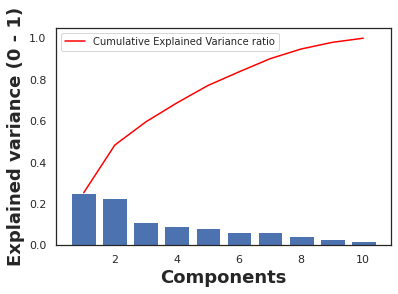

In [61]:
from sklearn.decomposition import PCA
pcamodel = PCA(n_components=10)
pca = pcamodel.fit_transform (Struc_New)

score = pca[:,0:2]
score[:,0].shape

xs = score[:,0]
ys = score[:,1]

pca.shape
plt.figure(figsize=(6,4))
#plt.figsize=(20.7,6.27)
plt.bar(range(1,len(pcamodel.explained_variance_ratio_ )+1),pcamodel.explained_variance_ratio_) #width=0.5
plt.ylabel('Explained variance (0 - 1)',fontsize = 18,fontweight='bold')
plt.xlabel('Components',fontsize = 18,fontweight='bold')# fontsize=18,fontweight='bold'
#plt.title(r"Training Sites: Explained Variance" + "\n" + "for Each Principal Component ",fontsize=28,fontweight='bold')


#plt.title('NMF distribution at Structures\n2D NMF/Kmeans clusters - ' + ' Numerical Features',fontsize=14,fontweight='bold');

plt.plot(range(1,len(pcamodel.explained_variance_ratio_ )+1),
         np.cumsum(pcamodel.explained_variance_ratio_),
         c='red',
         label="Cumulative Explained Variance ratio")
plt.legend(loc='upper left',fontsize = 10)
plt.tight_layout

In [62]:
pcamodel.explained_variance_ratio_

#Truncate PCA's if first 3 or 4 account for most of the variance
var_ratio1 = float(str(round(pcamodel.explained_variance_ratio_[0]*100, 2)))
var_ratio2 = float(str(round(pcamodel.explained_variance_ratio_[1]*100, 2)))
var_ratio3 = float(str(round(pcamodel.explained_variance_ratio_[2]*100, 2)))
var_ratio4 = float(str(round(pcamodel.explained_variance_ratio_[3]*100, 2)))

var_ratio1+var_ratio2+var_ratio3

59.61

<function matplotlib.pyplot.tight_layout>

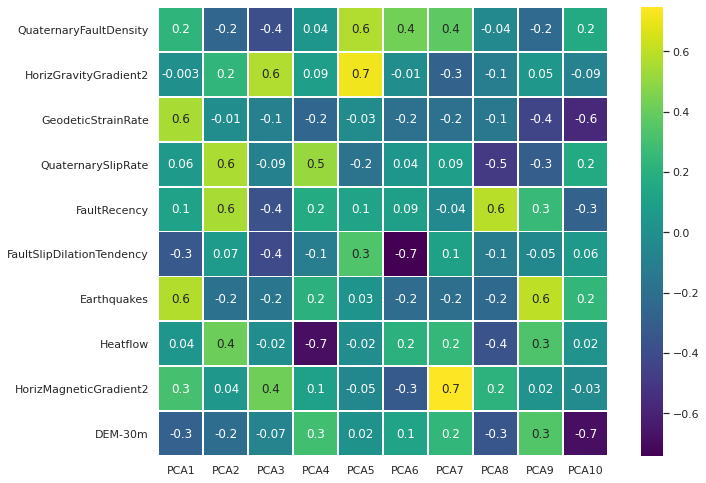

In [63]:
import seaborn as sns
#we can see influence on each of the components by features.
#fig= plt.figure(figsize=(18,13.5))
pcamodel.components_t= pcamodel.components_.transpose()

#ax.xaxis.set_tick_params(labelsize=20)

#im = ax.imshow(W.transpose(), cmap = 'viridis') # cmap='YlGnBu'

sns.set(rc={'figure.figsize':(11.7,8.27),"font.size":20,"axes.labelsize":20},style="white")
ax = sns.heatmap(pcamodel.components_t,  cmap = 'viridis',
                  linewidths=.95,
                 xticklabels=([ "PCA"+str(Struc_New) for Struc_New  in range(1,pcamodel.n_components_+1)]),
                 yticklabels=list(Struc_New.columns), 
                 annot=True, annot_kws={"size": 12}, fmt='.1g',
                 cbar_kws={"orientation": "vertical"})
#xticklabels_kws={"size":15}
#ax.set_xlabel("X Label",fontsize=30)
ax.fontweight='bold'
ax.set_aspect("equal")
#ax.set_tick_params(labelsize = 20)
#ax.set_xticklabels(labelsize = 20)
#ax.invert_yaxis()
plt.tight_layout


### PCA reconstruction for clustering

In [64]:
Struc_New_labeled['PC1'] = pca[:,0]
Struc_New_labeled['PC2'] = pca[:,1]
Struc_New_labeled['PC3'] = pca[:,2]
Struc_New_labeled['PC4'] = pca[:,3]

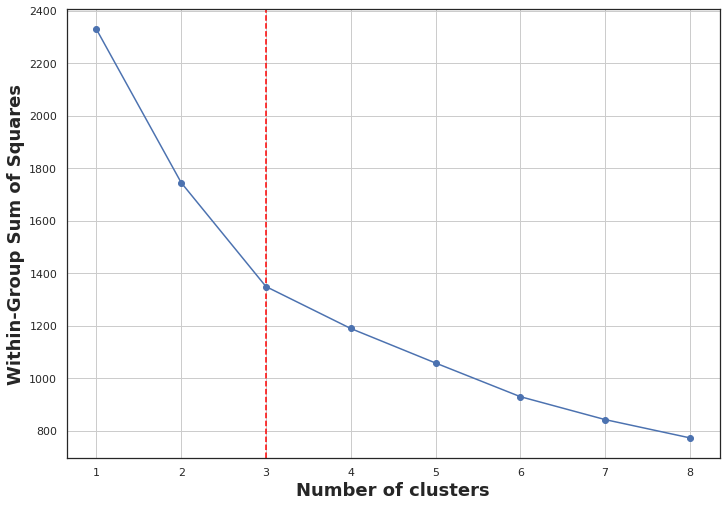

In [66]:
distortions = []
for i in range(1, 9):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, 
        max_iter=50,
        tol=1e-04, random_state=0
    ) 

    #K-means on the first 4 or so PCs which explain the most variance
    km.fit(Struc_New_labeled[['PC1','PC2','PC3','PC4']])
    distortions.append(km.inertia_)

xposition = [3]
for xc in xposition:
    plt.axvline(x=xc, color='red', linestyle='--')
 
# plot
#plt.plot(figsize =(10,10))
plt.plot(range(1, 9), distortions, marker='o')
plt.xlabel('Number of clusters',fontsize = 18,fontweight='bold')
plt.ylabel('Within-Group Sum of Squares',fontsize = 18,fontweight='bold')
#plt.title('Pos sites K vs distortion')

plt.grid()
plt.show()

### PCA Kmeans clustering

In [67]:
STR_reset = Struc_New_labeled.reset_index( drop=True,inplace = False, col_level=0, col_fill='')
STR = pd.DataFrame(STR_reset)
from sklearn.cluster import KMeans
cols = STR.columns


nCluster = 3

KmeanSR = KMeans(n_clusters=nCluster, init='k-means++',
               verbose=2, algorithm="elkan",
               n_init=10, max_iter=300, tol=0.000001)

KmeanSR.fit(STR[['PC1','PC2']])

Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 733.266703073657
start iteration
done sorting
end inner loop
Iteration 1, inertia 692.2095285195769
start iteration
done sorting
end inner loop
Iteration 2, inertia 670.086423047736
start iteration
done sorting
end inner loop
Iteration 3, inertia 661.5383973720621
start iteration
done sorting
end inner loop
Iteration 4, inertia 659.9059285079207
start iteration
done sorting
end inner loop
Iteration 5, inertia 659.5689904233307
start iteration
done sorting
end inner loop
Iteration 6, inertia 659.5689904233307
center shift 0.000000e+00 within tolerance 2.245460e-06
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 684.4257979817567
start iteration
done sorting
end inner loop
Iteration 1, inertia 663.8279669555172
start iteration
done sorting
end inner loop
Iteration 2, inertia 659.509342913228
start iteration
done sorting
end inner loop
Iteration 3, inertia 659.

KMeans(algorithm='elkan', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=1e-06, verbose=2)

In [68]:
centers = np.copy(KmeanSR.cluster_centers_)
print('centers.ndim: {}'.format(centers.ndim))
print('centers.shape: {}'.format(centers.shape))
print('centers.size: {}'.format(centers.size))
print(centers)

Labels = KmeanSR.labels_

centers.ndim: 2
centers.shape: (3, 2)
centers.size: 6
[[ 1.86935909 -0.10721773]
 [-0.90635154 -1.04694546]
 [-0.6135066   1.60064415]]


In [69]:
df_labels = pd.DataFrame({'KMeansGrp':Labels,
                          'Grp0_CntrX':centers[0,0],
                          'Grp0_CntrY':centers[0,1],
                          'Grp1_CntrX':centers[1,0],
                          'Grp1_CntrY':centers[1,1]})

df_out = pd.concat([STR, df_labels], axis=1, sort=False)

print("Last 5 rows of df_out:", file=sys.stdout, flush=True)
print(df_out.tail(5).to_string(), file=sys.stdout, flush=True)
print('', file=sys.stdout, flush=True)

Last 5 rows of df_out:
     QuaternaryFaultDensity  HorizGravityGradient2  GeodeticStrainRate  QuaternarySlipRate  FaultRecency  FaultSlipDilationTendency  Earthquakes  Heatflow  HorizMagneticGradient2   DEM-30m  TrainCodePos       PC1       PC2       PC3       PC4  KMeansGrp  Grp0_CntrX  Grp0_CntrY  Grp1_CntrX  Grp1_CntrY
360                1.579766               0.715068           -0.538849           -0.759298     -0.665293                  -0.596084    -0.321885 -0.687452               -0.601185  0.936105            12 -1.035533 -1.849538  0.243149  0.382422          1    1.869359   -0.107218   -0.906352   -1.046945
361               -0.578005               0.014247           -0.246328           -0.415788     -0.262435                  -0.130414    -0.916798 -1.150228               -0.852408  1.018112            12 -1.915133 -1.140609  0.265925  0.545699          1    1.869359   -0.107218   -0.906352   -1.046945
362               -1.439074              -0.193307           -0.039269 

In [70]:
group1 = df_out[(df_out['TrainCodePos'] == 1) & (df_out['KMeansGrp'] == 0)] #plot with star
group2 = df_out[(df_out['TrainCodePos'] == 12) & (df_out['KMeansGrp'] == 0)]
group3 = df_out[(df_out['TrainCodePos'] == 1) & (df_out['KMeansGrp'] == 1)] #plot with star
group4 = df_out[(df_out['TrainCodePos'] == 12) & (df_out['KMeansGrp'] == 1)]
group5 = df_out[(df_out['TrainCodePos'] == 1) & (df_out['KMeansGrp'] == 2)] #plot with star
group6 = df_out[(df_out['TrainCodePos'] == 12) & (df_out['KMeansGrp'] == 2)]

In [71]:

#XyInfo.reset_index(inplace = True) 
group1_info = pd.concat([group1,df_mean_struct], axis=1, sort=False).dropna() ### UPDATE IF Tsite_Pos or Tsite_Neg if you are switching!
group2_info = pd.concat([group2,df_mean_struct], axis=1, sort=False).dropna()
group3_info = pd.concat([group3,df_mean_struct], axis=1, sort=False).dropna()
group4_info = pd.concat([group4,df_mean_struct], axis=1, sort=False).dropna()
group5_info = pd.concat([group5,df_mean_struct], axis=1, sort=False).dropna()
group6_info = pd.concat([group6,df_mean_struct], axis=1, sort=False).dropna()

In [72]:
label1 = 'Struc w/ KGS ' + 'G1: ' + str(len(group5))
label2 = 'Struc ' + 'G1: ' + str(len(group6))
label3 = 'Struc w/KGS '+'G2: ' + str(len(group3))
label4 = 'Struc '+'G2: ' + str(len(group4))
label5 = 'Struc w/ KGS '+'G3: ' + str(len(group1))
label6 = 'Struc '+ 'G3: ' + str(len(group2))

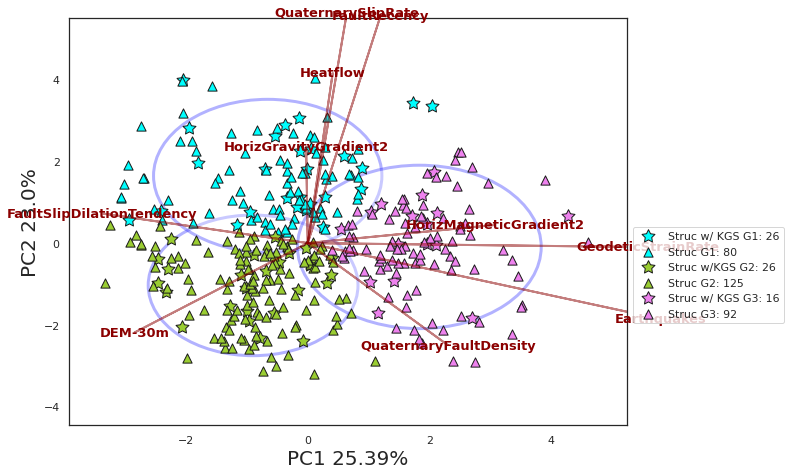

In [73]:
plt.subplots(figsize=(10,7.5))
plt.scatter(group5['PC1'], group5['PC2'], c='cyan',edgecolors='k',s=185,marker=(5, 1), label=label1)
plt.scatter(group6['PC1'], group6['PC2'], c='cyan',edgecolors='k',s=85, marker='^',label=label2)
plt.scatter(group3['PC1'], group3['PC2'], c='yellowgreen',edgecolors='k',s=185, marker=(5, 1), label=label3)
plt.scatter(group4['PC1'], group4['PC2'], c='yellowgreen',edgecolors='k',s=85, marker='^',label=label4)
plt.scatter(group1['PC1'], group1['PC2'], c='violet',edgecolors='k',s=185, marker=(5, 1),label=label5)
plt.scatter(group2['PC1'], group2['PC2'], c='violet',edgecolors='k',s=85, marker='^',label=label6)


#ADD ELLIPSES
def plot_kmeans(kmeans, X, n_clusters=3, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
    #ax.axis('equal') #equal makes them circles
    #ax.set_ylim(-5000,7000)
    #ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_ 
    radii = [cdist(X[labels == i], [center]).mean()*0.75
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='white',ec ='blue', lw=3, alpha = 0.3, zorder=.1))

#ADD VECTORS
def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    #plt.scatter(xs * scalex,ys * scaley,s=5, color ='white')
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0]*10, coeff[i,1]*10,color = 'darkred',alpha = 0.5, lw = 2 )
        if labels is None:
            plt.text(coeff[i,0]* 1.05, coeff[i,1] * 1.05, "Var"+str(i+1), color = 'k', ha = 'center', va = 'center',)
#            plt.text(coeff[i,0]*0.95, coeff[i,1]*0.95, "Var"+str(i+1), color = 'green', ha = 'center', va = 'center')

        else:
            plt.text(coeff[i,0]* 10.05, coeff[i,1] * 10.05, labels[i], color = 'darkred', ha = 'center', va = 'center',fontsize=13,fontweight='bold')
       #     plt.text(coeff[i,0], coeff[i,1], labels[i], color = 'g', ha = 'center', va = 'center')
 
    plt.xlabel('PC1 ' + str(var_ratio1) + '%',fontsize=20)
    plt.ylabel('PC2 ' + str(var_ratio2) + '%',fontsize=20)


scale_factor = 1.25

scale_factor_x = 1.05

xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()

plt.xlim(xmin * scale_factor_x, xmax * scale_factor_x)
plt.ylim(ymin * scale_factor, ymax * scale_factor)        

kmeans = KMeans(n_clusters=3, random_state=0)

plot_kmeans(kmeans, pca) # hash out to turn off ellipses

myplot(pca[:,0:2],np.transpose(pcamodel.components_[0:2, :]),list(Struc_New.columns))

#scale_factor = 1.55
plt.legend(loc='best',bbox_to_anchor=(1, 0.5))
#scale_factor_x = 1.25
#plt.grid(True)
#plt.title('KMeans Analysis with\n2D PCA clusters - ' + ' dfN' ' local',fontsize=14);

### Projection into fairway

(1728000,)


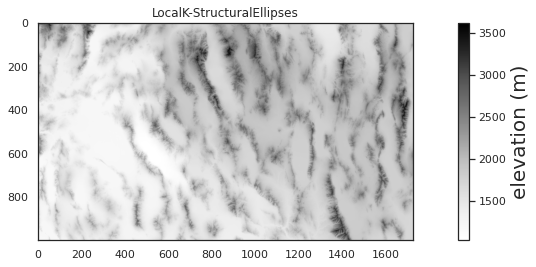

In [74]:
#Set up DEM that isn't normalized (original values) to overlay data on
selected_columns = df_features[['DEM-30m','X_83UTM11','Y_83UTM11']]
df_DEM = selected_columns.copy()
SD = df_DEM['DEM-30m'].to_numpy().astype(float)
print(SD.shape)
plt.rc('figure', figsize=(16,4))
SD =np.reshape(SD,(1000,1728))
#SD =np.reshape(SD,(1263,1344))
plt.imshow(SD,cmap ='Greys')
plt.title('LocalK-StructuralEllipses')

plt.colorbar(label = 'elevation (m)')

<function matplotlib.pyplot.tight_layout>

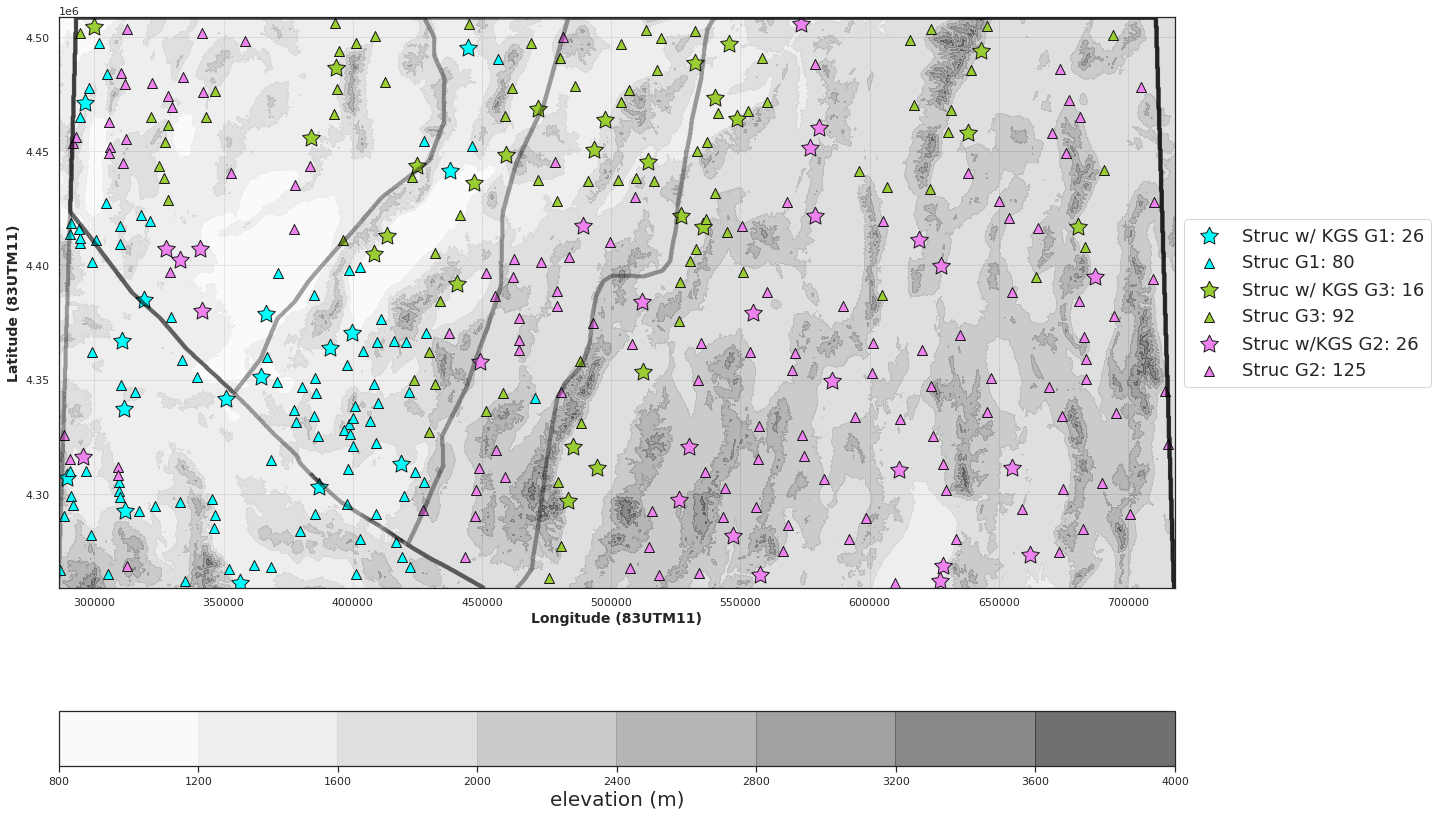

In [75]:
plt.subplots(figsize=(20,15))

a = df_features['X_83UTM11']
b = df_features['Y_83UTM11']
s = df_features['QuaternaryFaultTraces']

Z = Info.pivot_table(index='X_83UTM11', columns='Y_83UTM11', values='Domain').T.values #-9999 in strain messses it up

Za = df_DEM.pivot_table(index='X_83UTM11', columns='Y_83UTM11', values='DEM-30m').T.values #-9999 in strain messses it up

X_unique = np.sort(a.unique())
Y_unique = np.sort(b.unique())
Xa, Ya = np.meshgrid(X_unique, Y_unique)
pd.DataFrame(Z)

#plt.subplot(2,2,1)
plt.rcParams["figure.figsize"] = (20,10)

alpha = 0.7

plt.contour(Xa,Ya,Z,colors='black', linewidths=4, alpha=0.2) #cmap = 'terrain'

plt.contourf(Xa,Ya,Za,cmap = 'Greys', alpha=0.6)
plt.colorbar(label = 'elevation (m)',orientation= 'horizontal')


plt.scatter(group1_info['X_83UTM11'], group1_info['Y_83UTM11'], c='cyan',edgecolors='k', marker=(5, 1),s=345, label=label1)
plt.scatter(group2_info['X_83UTM11'], group2_info['Y_83UTM11'],  c='cyan', edgecolors='k',marker='^',s=100, label=label2)
plt.scatter(group5_info['X_83UTM11'], group5_info['Y_83UTM11'],  c='yellowgreen',edgecolors='k', marker=(5, 1),s=345, label=label5)
plt.scatter(group6_info['X_83UTM11'], group6_info['Y_83UTM11'],  c='yellowgreen',edgecolors='k', marker='^',s=100, label=label6)
plt.scatter(group3_info['X_83UTM11'], group3_info['Y_83UTM11'],  c='violet',edgecolors='k', marker=(5, 1),s=345, label=label3)
plt.scatter(group4_info['X_83UTM11'], group4_info['Y_83UTM11'],  c='violet', edgecolors='k',marker='^',s=100, label=label4)

plt.xlabel('Longitude (83UTM11)',fontsize=14,fontweight='bold')
plt.ylabel('Latitude (83UTM11)',fontsize=14,fontweight='bold')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize = 18)
plt.grid(True)
#plt.colorbar(orientation= 'horizontal')

#plt.title('PCA distribution at Structures\n2D PCA/Kmeans clusters - ' + ' Numerical Features',fontsize=14,fontweight='bold');

#plt.colorbar()
plt.tight_layout

have to figure out how to include these in biplot, for now I am lazy I just use photoshop 

## PCA with Domains/Fairway

In [ ]:
from sklearn.decomposition import PCA
pcamodel = PCA(n_components=10)
pca = pcamodel.fit_transform (FRWY)

score = pca[:,0:2]
score[:,0].shape

xs = score[:,0]
ys = score[:,1]

pca.shape
plt.figure(figsize=(6,4))
#plt.figsize=(20.7,6.27)
plt.bar(range(1,len(pcamodel.explained_variance_ratio_ )+1),pcamodel.explained_variance_ratio_) #width=0.5
plt.ylabel('Explained variance (0 - 1)',fontsize = 18,fontweight='bold')
plt.xlabel('Components',fontsize = 18,fontweight='bold')# fontsize=18,fontweight='bold'
#plt.title(r"Training Sites: Explained Variance" + "\n" + "for Each Principal Component ",fontsize=28,fontweight='bold')


#plt.title('NMF distribution at Structures\n2D NMF/Kmeans clusters - ' + ' Numerical Features',fontsize=14,fontweight='bold');

plt.plot(range(1,len(pcamodel.explained_variance_ratio_ )+1),
         np.cumsum(pcamodel.explained_variance_ratio_),
         c='red',
         label="Cumulative Explained Variance ratio")
plt.legend(loc='upper left',fontsize = 10)
plt.tight_layout

In [ ]:
import seaborn as sns
#we can see influence on each of the components by features.
#fig= plt.figure(figsize=(18,13.5))
pcamodel.components_t= pcamodel.components_.transpose()

#ax.xaxis.set_tick_params(labelsize=20)

#im = ax.imshow(W.transpose(), cmap = 'viridis') # cmap='YlGnBu'

sns.set(rc={'figure.figsize':(11.7,8.27),"font.size":20,"axes.labelsize":20},style="white")
ax = sns.heatmap(pcamodel.components_t,  cmap = 'viridis',
                  linewidths=.95,
                 xticklabels=([ "PCA"+str(FRWY) for FRWY  in range(1,pcamodel.n_components_+1)]),
                 yticklabels=list(FRWY.columns), 
                 annot=True, annot_kws={"size": 12}, fmt='.1g',
                 cbar_kws={"orientation": "vertical"})
#xticklabels_kws={"size":15}
#ax.set_xlabel("X Label",fontsize=30)
ax.fontweight='bold'
ax.set_aspect("equal")
#ax.set_tick_params(labelsize = 20)
#ax.set_xticklabels(labelsize = 20)
#ax.invert_yaxis()
plt.tight_layout

In [ ]:
pcamodel.explained_variance_ratio_

var_ratio1 = float(str(round(pcamodel.explained_variance_ratio_[0]*100, 2)))
var_ratio2 = float(str(round(pcamodel.explained_variance_ratio_[1]*100, 2)))
var_ratio3 = float(str(round(pcamodel.explained_variance_ratio_[2]*100, 2)))
var_ratio4 = float(str(round(pcamodel.explained_variance_ratio_[3]*100, 2)))

var_ratio1+var_ratio2+var_ratio3

In [ ]:
#This function plots loading vectors 
fig= plt.figure(figsize=(15,10.5)) #,linewidth=10, edgecolor="#04253a")

scalex = 2.5/(xs.max() - xs.min())
scaley = 2.5/(ys.max() - ys.min())
#plt.scatter(xs * scalex,ys * scaley,s=5)


scalex = 1.0/(xs.max() - xs.min())
scaley = 1.0/(ys.max() - ys.min())



var_ratio1 = float(str(round(pcamodel.explained_variance_ratio_[0]*100, 2)))
var_ratio2 = float(str(round(pcamodel.explained_variance_ratio_[1]*100, 2)))

def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 2.0/(xs.max() - xs.min())
    scaley = 2.0/(ys.max() - ys.min())
    #plt.scatter(xs * scalex,ys * scaley,s=5)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'darkred',alpha = 0.5, lw = 2 )
        if labels is None:
            plt.text(coeff[i,0]* 1.05, coeff[i,1] * 1.05, "Var"+str(i+1), color = 'k', ha = 'center', va = 'center')
#            plt.text(coeff[i,0]*0.95, coeff[i,1]*0.95, "Var"+str(i+1), color = 'green', ha = 'center', va = 'center')

        else:
            plt.text(coeff[i,0]* 1.05, coeff[i,1] * 1.05, labels[i], color = 'darkred', ha = 'center', va = 'center',fontsize=13, fontweight = 'bold')
       #     plt.text(coeff[i,0], coeff[i,1], labels[i], color = 'g', ha = 'center', va = 'center')
 
    plt.xlabel('PC1 ' + str(var_ratio1) + '%',fontsize=20)
    plt.ylabel('PC2 ' + str(var_ratio2) + '%',fontsize=20)
   # plt.grid()

#plt.plot(pca[y == 0,0]*scalex,pca[y == 0,1]*scalex, color='purple',s=55, label='Negative T-Site')

plt.scatter(xs * scalex,ys * scaley,s=5)
plt.scatter(pca[Info['TrainCodeNeg']==1,0]*scalex,pca[Info['TrainCodeNeg']==1,1]*scalex, color='purple',s=55, label='Negative T-Site')
plt.scatter(pca[Info['TrainCodePosT130']==1,0]*scalex,pca[Info['TrainCodePosT130']==1,1]*scalex,color='red',edgecolors='k',s=200,marker=(5, 1),label='Positive T-Site(>130°C)')

plt.scatter(pca[Info['T37']==1,0]*scalex,pca[Info['T37']==1,1]*scalex,color='yellow',edgecolors='k',s=200,marker='^',label='Positive T-Site (39-130°C)')

#T37 = Tsite[(Tsite['TrainCodePosT130'] == 12) & (Tsite['TrainCodeNeg'] == 12)]

#plt.scatter(pca[WGB['NegSite_Id']==1,0]*scalex,pca[WGB['NegSite_Id']==1,1]*scalex, color='yellow',edgecolors='k',s=200,marker='^',label='Positive T-Site (39-130°C)')

myplot(pca[:,0:2],np.transpose(pcamodel.components_[0:2 :]),list(WalkLne.columns))
plt.legend(scatterpoints=1,loc='center left',bbox_to_anchor=(1, 0.5),fontsize=20)
plt.title('Fairway',fontsize=28,fontweight='bold')
plt.show()

In [ ]:
Info['PC1'] = pca[:,0]
Info['PC2'] = pca[:,1]
Info['PC3'] = pca[:,2]
Info['PC4'] = pca[:,3]

### PCA reconstruction for clustering

In [ ]:
plt.figure(figsize=(6,4))

distortions = []
for i in range(1, 9):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, 
        max_iter=50,
        tol=1e-04, random_state=0
    ) 

    #K-means on the first 4 or so PCs which explain the most variance
    km.fit(FRWY[['PC1','PC2','PC3','PC4']])
    distortions.append(km.inertia_)

xposition = [3]
for xc in xposition:
    plt.axvline(x=xc, color='red', linestyle='--')
 
# plot
#plt.plot(figsize =(10,10))
plt.plot(range(1, 9), distortions, marker='o')
plt.xlabel('Number of clusters',fontweight='bold')
plt.ylabel('Within-Group Sum of Squares',fontweight='bold')
#plt.title('Pos sites K vs distortion')

plt.grid()
plt.show()

### PCA Kmeans clustering

In [ ]:
#Kmeans

FRWY_reset = Info.reset_index( drop=True,inplace = False, col_level=0, col_fill='')
FW = pd.DataFrame(FRWY_reset)
from sklearn.cluster import KMeans
cols = FW.columns


nCluster = 3

KmeanPP = KMeans(n_clusters=nCluster, init='k-means++',
               verbose=2, algorithm="elkan",
               n_init=10, max_iter=300, tol=0.000001)

KmeanPP.fit(FW[['PC1','PC2','PC3']])

In [ ]:
centers = np.copy(KmeanPP.cluster_centers_)
print('centers.ndim: {}'.format(centers.ndim))
print('centers.shape: {}'.format(centers.shape))
print('centers.size: {}'.format(centers.size))
print(centers)

Labels = KmeanPP.labels_

In [ ]:
df_labels = pd.DataFrame({'KMeansGrp':Labels,
                          'Grp0_CntrX':centers[0,0],
                          'Grp0_CntrY':centers[0,1],
                          'Grp1_CntrX':centers[1,0],
                          'Grp1_CntrY':centers[1,1]})

df_out = pd.concat([Info, df_labels], axis=1, sort=False)

print("Last 5 rows of df_out:", file=sys.stdout, flush=True)
print(df_out.tail(5).to_string(), file=sys.stdout, flush=True)
print('', file=sys.stdout, flush=True)

In [ ]:
#XyInfo.reset_index(inplace = True) 
#df_PCATsite = pd.concat([df_out,XyInfo], axis=1, sort=False).dropna()

In [ ]:
#df_PCATsite.to_csv(index=False)

#df_PCATsite.to_csv('dfTsite2.csv')
#!cp df.csv "/content/drive/My Drive/October_PFA"

In [ ]:
group1 = df_out[(df_out['TrainCodePos'] == 1) & (df_out['KMeansGrp'] == 0)]
group2 = df_out[df_out['KMeansGrp']==0]

group3 = df_out[(df_out['TrainCodePos'] == 1) & (df_out['KMeansGrp'] == 1)]
group4 = df_out[df_out['KMeansGrp']==1]

group5 = df_out[(df_out['TrainCodePos'] == 1) & (df_out['KMeansGrp'] == 2)]
group6 = df_out[df_out['KMeansGrp']==2]

group7 = df_out[(df_out['TrainCodePos'] == 1) & (df_out['KMeansGrp'] == 3)]
group8 = df_out[df_out['KMeansGrp']==3]

group9 = df_out[(df_out['TrainCodeNeg'] == 1) & (df_out['KMeansGrp'] == 0)]
group10 = df_out[(df_out['TrainCodeNeg'] == 1) & (df_out['KMeansGrp'] == 1)]
group11 = df_out[(df_out['TrainCodeNeg'] == 1) & (df_out['KMeansGrp'] == 2)]
group12 = df_out[(df_out['TrainCodeNeg'] == 1) & (df_out['KMeansGrp'] == 3)]


group13 = df_out[(df_out['Local_polygon_Id'] != 0) & (df_out['KMeansGrp'] == 0)]
group14 = df_out[(df_out['Local_polygon_Id'] != 0) & (df_out['KMeansGrp'] == 1)]
group15 = df_out[(df_out['Local_polygon_Id'] != 0) & (df_out['KMeansGrp'] == 2)]
group16 = df_out[(df_out['Local_polygon_Id'] != 0) & (df_out['KMeansGrp'] == 3)]

In [ ]:
label1 = 'Positive T-Site - Cluster 1'
label2 = 'Cluster 1'
label3 = 'Positive T-Site - Cluster 2'
label4 = 'Cluster 2'
label5 = 'Positive T-Site - Cluster 3'
label6 = 'Cluster 3'
label7 = 'Positive T-Site - Cluster 4'
label8 = 'Cluster 4'
label9 = 'neg - cluster 1'
label10 = 'neg - cluster 2'
label11 = 'neg - cluster 3'
label12 = 'neg - cluster 4'
label9 = 'str - cluster 1'
label10 = 'str - cluster 2'
label11 = 'str - cluster 3'
label12 = 'str - cluster 4'

In [ ]:
plt.subplots(figsize=(20,14.5))


plt.scatter(group2['PC1'], group2['PC2'], c='cyan',edgecolors='k',s=6, marker='.',label=label2, alpha=0.3)
plt.scatter(group4['PC1'], group4['PC2'], c='yellowgreen',edgecolors='k',s=6, marker='.',label=label4, alpha=0.3)
plt.scatter(group6['PC1'], group6['PC2'], c='violet',edgecolors='k',s=6, marker='.',label=label6, alpha=0.3)
plt.scatter(group8['PC1'], group8['PC2'], c='pink',edgecolors='k',s=6, marker='.',label=label8, alpha=0.3)

plt.scatter(group13['PC1'], group13['PC2'], c='cyan',edgecolors='k',s=15,marker='^', label=label9)
plt.scatter(group14['PC1'], group14['PC2'], c='yellowgreen',edgecolors='k',s=15,marker='^', label=label10)
plt.scatter(group15['PC1'], group15['PC2'], c='violet',edgecolors='k',s=15,marker='^', label=label11)
plt.scatter(group16['PC1'], group16['PC2'], c='red',edgecolors='k',s=15,marker='^', label=label12)

plt.scatter(group9['PC1'], group9['PC2'], c='cyan',edgecolors='k',s=85,marker='o', label=label9)
plt.scatter(group10['PC1'], group10['PC2'], c='yellowgreen',edgecolors='k',s=85,marker='o', label=label10)
plt.scatter(group11['PC1'], group11['PC2'], c='violet',edgecolors='k',s=85,marker='o', label=label11)
plt.scatter(group12['PC1'], group12['PC2'], c='red',edgecolors='k',s=85,marker='o', label=label12)



plt.scatter(group1['PC1'], group1['PC2'], c='cyan',edgecolors='k',s=385,marker=(5, 1), label=label1)
plt.scatter(group3['PC1'], group3['PC2'], c='yellowgreen',edgecolors='k',s=385, marker=(5, 1), label=label3)
plt.scatter(group5['PC1'], group5['PC2'], c='violet',edgecolors='k',s=385, marker=(5, 1),label=label5)
plt.scatter(group7['PC1'], group7['PC2'], c='red',edgecolors='k',s=385, marker=(5, 1),label=label7)


#ADD ELLIPSES
def plot_kmeans(kmeans, X, n_clusters=3, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
    #ax.axis('equal') #equal makes them circles
    #ax.set_ylim(-5000,7000)
    #ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_ 
    radii = [cdist(X[labels == i], [center]).mean()*0.75
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='white',ec ='darkblue', lw=10, zorder=.1))

#ADD VECTORS
def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    #plt.scatter(xs * scalex,ys * scaley,s=5, color ='white')
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0]*10, coeff[i,1]*10,color = 'darkred',alpha = 0.9, lw = 5 )
        if labels is None:
            plt.text(coeff[i,0]* 1.05, coeff[i,1] * 1.05, "Var"+str(i+1), color = 'k', ha = 'center', va = 'center',)
#            plt.text(coeff[i,0]*0.95, coeff[i,1]*0.95, "Var"+str(i+1), color = 'green', ha = 'center', va = 'center')

        else:
            plt.text(coeff[i,0]* 10.05, coeff[i,1] * 10.05, labels[i], color = 'darkred', ha = 'center', va = 'center',fontsize=13,fontweight='bold')
       #     plt.text(coeff[i,0], coeff[i,1], labels[i], color = 'g', ha = 'center', va = 'center')
 
    plt.xlabel('PC1 ' + str(var_ratio1) + '%',fontsize=20)
    plt.ylabel('PC2 ' + str(var_ratio2) + '%',fontsize=20)


scale_factor = 1.55

scale_factor_x = 1.65

#xmin, xmax = plt.xlim()
#ymin, ymax = plt.ylim()
kmeans = KMeans(n_clusters=3, random_state=0)

plot_kmeans(kmeans, pca) # hash out to turn off ellipses

#plt.xlim(xmin * scale_factor_x, xmax * scale_factor_x)
#plt.ylim(ymin * scale_factor, ymax * scale_factor)        

myplot(pca[:,0:2],np.transpose(pcamodel.components_[0:2, :]),list(FRWY.columns))


#scale_factor = 1.55

#scale_factor_x = 1.25

xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()

#plt.xlim(xmin * scale_factor_x, xmax * scale_factor_x)
#plt.ylim(ymin * scale_factor, ymax * scale_factor)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5))


#plt.grid(True)
#plt.title('KMeans Analysis with\n2D PCA clusters - ' + ' dfN' ' local',fontsize=14);


### Projection into Fairway

In [ ]:
plt.subplots(figsize=(20,15))

a = df_features['X_83UTM11']
b = df_features['Y_83UTM11']
s = df_features['QuaternaryFaultTraces']

Z = Info.pivot_table(index='X_83UTM11', columns='Y_83UTM11', values='Domain').T.values #-9999 in strain messses it up

Za = df_DEM.pivot_table(index='X_83UTM11', columns='Y_83UTM11', values='DEM-30m').T.values #-9999 in strain messses it up

X_unique = np.sort(a.unique())
Y_unique = np.sort(b.unique())
Xa, Ya = np.meshgrid(X_unique, Y_unique)
pd.DataFrame(Z)

#plt.subplot(2,2,1)
plt.rcParams["figure.figsize"] = (20,10)

alpha = 0.7

plt.contour(Xa,Ya,Z,colors='black', linewidths=4, alpha=0.2) #cmap = 'terrain'

plt.contourf(Xa,Ya,Za,cmap = 'Greys', alpha=0.6)
plt.colorbar(label = 'elevation (m)',orientation= 'horizontal')

#plt.scatter(group6['X_83UTM11'], group6['Y_83UTM11'],  c='violet',edgecolors='k', marker='.',s=0.5, label=label6)

plt.scatter(group15['X_83UTM11'], group15['Y_83UTM11'], c='violet',edgecolors='k',s=15,marker='^', label=label11)

plt.scatter(group1['X_83UTM11'], group1['Y_83UTM11'], c='cyan',edgecolors='k', marker=(5, 1),s=245, label=label1)
#plt.scatter(group2['X_83UTM11'], group2['Y_83UTM11'],  c='cyan', edgecolors='k',marker='.',s=0.05, label=label2)
plt.scatter(group3['X_83UTM11'], group3['Y_83UTM11'],  c='yellowgreen',edgecolors='k', marker=(5, 1),s=245, label=label3)
#plt.scatter(group4['X_83UTM11'], group4['Y_83UTM11'],  c='cyan', edgecolors='k',marker='.',s=0.5, label=label4)
plt.scatter(group5['X_83UTM11'], group5['Y_83UTM11'],  c='violet',edgecolors='k', marker=(5, 1),s=245, label=label5)
plt.scatter(group7['X_83UTM11'], group7['Y_83UTM11'],  c='red', edgecolors='k',marker=(5, 1),s=245,label=label7)
#plt.scatter(group8['X_83UTM11'], group8['Y_83UTM11'],  c='violet', marker='.',s=0.5,edgecolors='k', label=label8)
plt.scatter(group9['X_83UTM11'], group9['Y_83UTM11'],  c='cyan', marker='o',edgecolors='k',s=95,label=label9)
#plt.scatter(z['X_83UTM11'],z['Y_83UTM11'], c = 'red', edgecolors='k', s=165, marker=(5, 1), label = labelS)
plt.scatter(group10['X_83UTM11'], group10['Y_83UTM11'],  c='yellowgreen', marker='o',edgecolors='k',s=95,label=label10)
plt.scatter(group11['X_83UTM11'], group11['Y_83UTM11'],  c='violet', marker='o',edgecolors='k',s=95,label=label11)
plt.scatter(group12['X_83UTM11'], group12['Y_83UTM11'],  c='red', marker='o',edgecolors='k',s=95,label=label12)



#plt.scatter(Tsite_Pos['X_83UTM11'],Tsite_Pos['Y_83UTM11'],c='pink', marker='o',s=145)

plt.xlabel('Longitude (83UTM11)',fontsize=14,fontweight='bold')
plt.ylabel('Latitude (83UTM11)',fontsize=14,fontweight='bold')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize = 18)
plt.grid(True)

#plt.title('PCA distribution at Structures\n2D PCA/Kmeans clusters - ' + ' Numerical Features',fontsize=14,fontweight='bold');

#plt.title('HGG')
#plt.ylabel('Y_83UTM11')
#plt.xlabel('X_83UTM11')
#plt.colorbar()
plt.tight_layout